In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import itertools
import statsmodels.api as sm
import pmdarima as pm

# Import Functions
from FP_Functions import * 


from matplotlib import pyplot
from math import sqrt
from datetime import datetime
from scipy.stats import uniform


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error



# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax



# prophet
import prophet
from prophet import Prophet

import mango
from mango import Tuner, scheduler


%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 8)
warnings.filterwarnings("ignore")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [75]:
lesing_Straße ='Lenstr_clean.csv'
data = pd.read_csv(lesing_Straße)
data['dateObserved'] = pd.to_datetime(data['dateObserved'])
data.dtypes

dateObserved        datetime64[ns, UTC]
intensity                       float64
filled_intensity                float64
dtype: object

In [76]:
data_ml = data.drop(columns = 'intensity')
data_ml = data_ml.set_index('dateObserved', drop=True)
data_ml['filled_intensity'].isna().sum()

0

# Machinelearning

## General Note:
Since we have a sufficient amount of data, I have decided to allocate a larger portion of it, specifically 80%, to the training set. This approach is based on observations from different results which indicate that giving the model more historical data to learn from can effectively capture the underlying patterns and seasonality. Consequently, this has been found to lead to better model performance.


## Feature Engineering

### Time Features:

In [77]:

# Extract datetime features
data_ml['year'] = data_ml.index.year
data_ml['month'] =data_ml.index.month
data_ml['day'] = data_ml.index.day
data_ml['date'] = data_ml.index.date
data_ml['hour'] = data_ml.index.hour
data_ml['minute'] = data_ml.index.minute
data_ml['dayofweek'] =data_ml.index.dayofweek
data_ml['is_weekend'] = data_ml.index.dayofweek.isin([5, 6]).astype(int)

# Rolling statistics
#window_size = 24*4   #24-hour cycle, each record is 15 minutes
#data_ml['rolling_mean'] = data_ml['filled_intensity'].rolling(window=window_size).mean()
#data_ml['rolling_std'] = data_ml['filled_intensity'].rolling(window=window_size).std()

# Lagged features
data_ml['lag_1'] = data_ml['filled_intensity'].shift(1)
data_ml['lag_2'] = data_ml['filled_intensity'].shift(2)


### Hoidays and Events

In [78]:
# adding holidays
holidays_2023 = {
    'New Year': '2023-01-01',
    'Epiphany': '2023-01-06',
    'Good Friday': '2023-04-07',
    'Easter Monday': '2023-04-10',
    'Labor Day': '2023-05-01',
    'Ascension Day': '2023-05-18',
    'Whit Monday': '2023-05-29',
    'Schlossbeleuchtungen1' :'2023-06-03',
    'Schlossbeleuchtungen2' :'2023-07-08',
    'Schlossbeleuchtungen3' :'2023-09-02',
    'Corpus Christi': '2023-06-08',
    'German Unity Day': '2023-10-03',
    'All Saints Day': '2023-11-01',
    'Christmas Day': '2023-12-25',
    'Second Day of Christmas': '2023-12-26',
    #'max_intensity' : '2023-10-27 13:25:00+00:00'
}


data_ml['is_holiday'] = 0


# Now check for holidays and set the 'is_holiday' flag
for name, date in holidays_2023.items():
    if date in data_ml.date:
        data_ml.loc[date, 'is_holiday'] = 1




        
data_ml.is_holiday.sum()

1344

In [79]:
data_ml.isna().sum()

filled_intensity    0
year                0
month               0
day                 0
date                0
hour                0
minute              0
dayofweek           0
is_weekend          0
lag_1               1
lag_2               2
is_holiday          0
dtype: int64

In [80]:
data_ml.lag_1.fillna(method='bfill', inplace=True)
data_ml.lag_2.fillna(method='bfill', inplace=True)
data_ml.isna().sum()

filled_intensity    0
year                0
month               0
day                 0
date                0
hour                0
minute              0
dayofweek           0
is_weekend          0
lag_1               0
lag_2               0
is_holiday          0
dtype: int64

## Arima-Sarimax

### Testing stationarity Using the Augmented Dickey-Fuller and Kwiatkowski-Phillips-Schmidt-Shin tests:

ADF test focuses on the presence of a unit root, and a low p-value indicates that the time series does not have a unit root, suggesting it might be stationary.
<br>KPSS test focuses on the presence of trends, and a low p-value indicates non-stationarity due to a trend.

In [81]:
warnings.filterwarnings("ignore")


# freq.15min 
data_ml = data_ml.asfreq('15min')

data_diff_1 = data_ml.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('\n\nFrequency 15_mins')

print('Test stationarity for original series Frequency 15mins')
print('-------------------------------------')

adfuller_result = adfuller(data_ml.filled_intensity)
kpss_result = kpss(data_ml.filled_intensity)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1.filled_intensity)
kpss_result = kpss(data_diff_1.filled_intensity)

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2.filled_intensity)
kpss_result = kpss(data_diff_2.filled_intensity) 

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

#=====================================================================

# Freq: Business Days

data_mlbd = data_ml[data_ml.index.dayofweek < 5]
data_mlbd = data_mlbd.asfreq('B') # bussinues days 


data_diff_1 = data_mlbd.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('\n\nFrequency Business_Day')

print('\nTest stationarity for original series Frequency Business_Days')
print('-------------------------------------')
adfuller_result = adfuller(data_mlbd.filled_intensity)
kpss_result = kpss(data_mlbd.filled_intensity)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1.filled_intensity)
kpss_result = kpss(data_diff_1.filled_intensity) 

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2.filled_intensity)
kpss_result = kpss(data_diff_2.filled_intensity)  

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

#=====================================================================

# Freq: Days

data_mld = data_ml.asfreq('D') #dayli


data_diff_1 = data_mld.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('\n\nFrequency Day')
print('\nTest stationarity for original series Frequency Days')
print('-------------------------------------')
adfuller_result = adfuller(data_mld.filled_intensity)
kpss_result = kpss(data_mld.filled_intensity)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1.filled_intensity)
kpss_result = kpss(data_diff_1.filled_intensity)  

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2.filled_intensity)
kpss_result = kpss(data_diff_2.filled_intensity)  

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')


#=====================================================================

# Freq: Weeks

data_mlw = data_ml.asfreq('W') # weekly frequency


data_diff_1 = data_mlw.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('\n\nFrequency Week')
print('\nTest stationarity for original series Frequency Week')
print('-------------------------------------')
adfuller_result = adfuller(data_mlw.filled_intensity)
kpss_result = kpss(data_mlw.filled_intensity)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1.filled_intensity)
kpss_result = kpss(data_diff_1.filled_intensity)  

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2.filled_intensity)
kpss_result = kpss(data_diff_2.filled_intensity)  

print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')



Frequency 15_mins
Test stationarity for original series Frequency 15mins
-------------------------------------
ADF Statistic: -28.538550769567266, p-value: 0.0
KPSS Statistic: 9.821786977979407, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -43.30049691979144, p-value: 0.0
KPSS Statistic: 0.0004905997744760106, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -40.599193032489815, p-value: 0.0
KPSS Statistic: 0.010988319824942066, p-value: 0.1


Frequency Business_Day

Test stationarity for original series Frequency Business_Days
-------------------------------------
ADF Statistic: -2.9888837912531954, p-value: 0.0359456358904957
KPSS Statistic: 1.7846472583924124, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -14.632713044469186, p-va

### Business days

In [82]:
data_mlbd.head(5)

,filled_intensity,year,month,day,date,hour,minute,dayofweek,is_weekend,lag_1,lag_2,is_holiday
dateObserved,,,,,,,,,,,,
2023-01-03 13:40:00+00:00,67.0,2023,1,3,2023-01-03,13,40,1,0,67.0,67.0,0
2023-01-04 13:40:00+00:00,62.0,2023,1,4,2023-01-04,13,40,2,0,64.0,60.0,0
2023-01-05 13:40:00+00:00,88.0,2023,1,5,2023-01-05,13,40,3,0,70.0,78.0,0
2023-01-06 13:40:00+00:00,51.0,2023,1,6,2023-01-06,13,40,4,0,44.0,40.0,1
2023-01-09 13:40:00+00:00,84.0,2023,1,9,2023-01-09,13,40,0,0,84.0,74.0,0


In [83]:
data_mlbd.is_holiday.sum()

11

Train dates : 2023-01-03 13:40:00+00:00 --- 2023-10-19 13:40:00+00:00  (n=208)
Test dates  : 2023-10-20 13:40:00+00:00 --- 2024-01-02 13:40:00+00:00  (n=53)


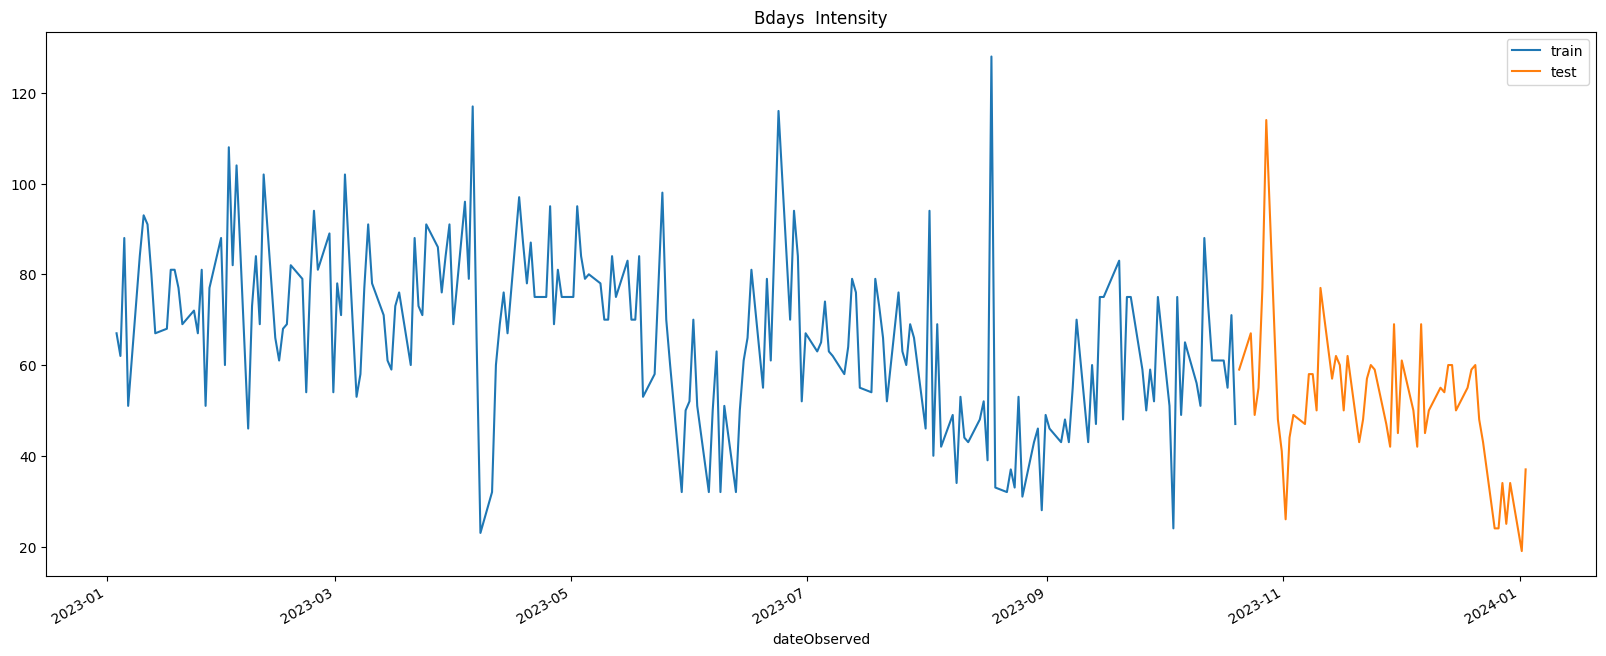

In [84]:
# Train-test dates
iloc_TrainEnd =int(data_mlbd.shape[0] - np.ceil(data_mlbd.shape[0]*0.2))
print(f"Train dates : {data_mlbd.index.min()} --- {data_mlbd.iloc[:iloc_TrainEnd].index.max()}  (n={len(data_mlbd.iloc[:iloc_TrainEnd])})")
print(f"Test dates  : {data_mlbd.iloc[iloc_TrainEnd:].index.min()} --- {data_mlbd.iloc[:].index.max()}  (n={len(data_mlbd.iloc[iloc_TrainEnd:])})")
data_train = data_mlbd.iloc[:iloc_TrainEnd]
data_test  = data_mlbd.iloc[iloc_TrainEnd:]

fig, ax = plt.subplots(figsize=(20,8))
data_train.plot(ax=ax, y='filled_intensity', label='train')  
data_test.plot(ax=ax, y='filled_intensity', label='test')   
ax.set_title('Bdays  Intensity')
ax.legend()

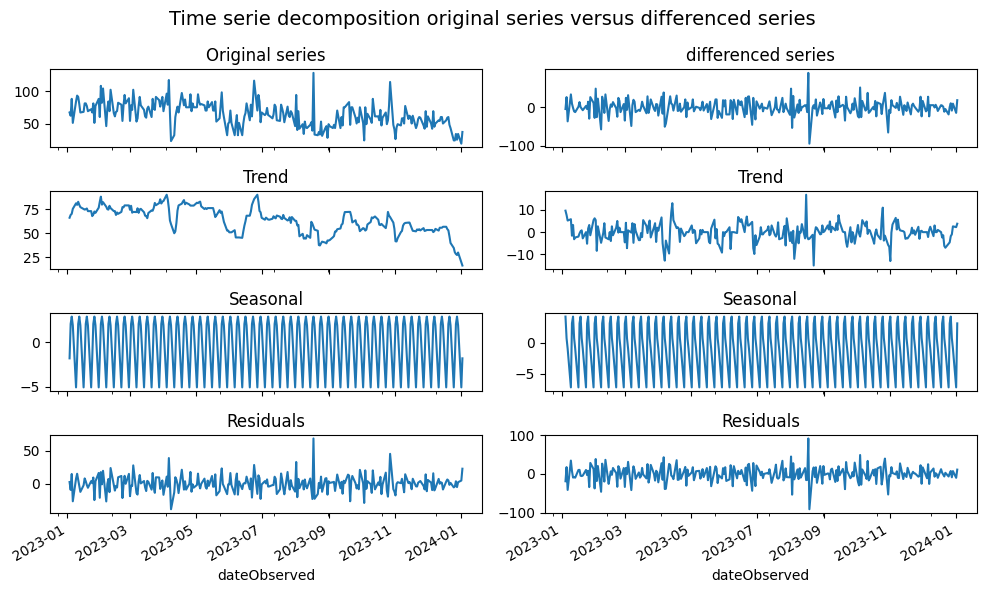

In [85]:
# Time series descoposition of original versus differenced series
# ==============================================================================

res_decompose = seasonal_decompose(data_mlbd.filled_intensity, model='additive', extrapolate_trend='freq')
data_diff_1 = data_mlbd.diff().dropna()
res_decompose2 = seasonal_decompose(data_diff_1.filled_intensity, model='additive', extrapolate_trend='freq')


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0,0])
axs[0,0].set_title('Original series')
res_decompose.trend.plot(ax=axs[1,0])
axs[1,0].set_title('Trend')
res_decompose.seasonal.plot(ax=axs[2,0])
axs[2,0].set_title('Seasonal')
res_decompose.resid.plot(ax=axs[3,0])
axs[3,0].set_title('Residuals')

res_decompose2.observed.plot(ax=axs[0,1])
axs[0,1].set_title('differenced series')
res_decompose2.trend.plot(ax=axs[1,1])
axs[1,1].set_title('Trend')
res_decompose2.seasonal.plot(ax=axs[2,1])
axs[2,1].set_title('Seasonal')
res_decompose2.resid.plot(ax=axs[3,1])
axs[3,1].set_title('Residuals')

fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();


#### Autocorrelation and Partial autocorrelation plots for original and differenced series


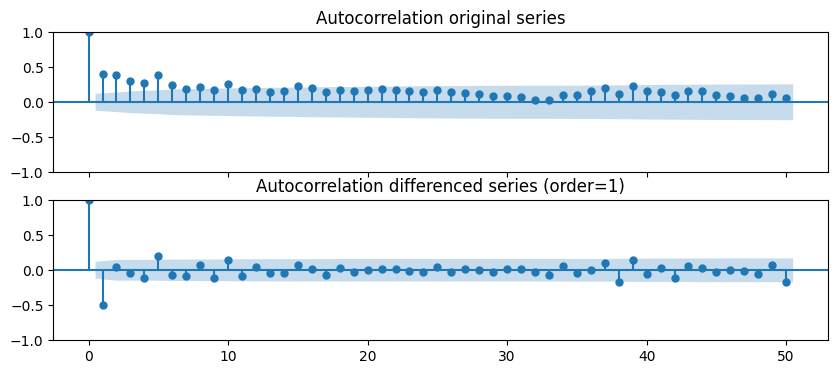

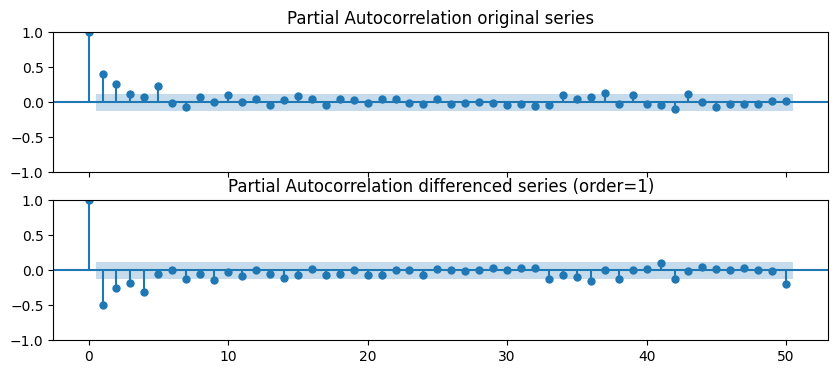

In [86]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
plot_acf(data_mlbd.filled_intensity, ax=axs[0], lags=50, alpha=0.05) 
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1.filled_intensity, ax=axs[1], lags=50, alpha=0.05)  
axs[1].set_title('Autocorrelation differenced series (order=1)');

# Partial autocorrelation plot for original and differenced series
# ==============================================================================

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
plot_pacf(data_mlbd.filled_intensity, ax=axs[0], lags=50, alpha=0.05) 
axs[0].set_title('Partial Autocorrelation original series')
plot_pacf(data_diff_1.filled_intensity, ax=axs[1], lags=50, alpha=0.05)  
axs[1].set_title('Partial Autocorrelation differenced series (order=1)');


#### Grid Search

In [87]:
#Parameter Grids
p = P = range(1, 4)
d = D = q = range (0,1)
Q = range(0, 2)  # Seasonal orders
S = [5]  # 5 Bdays, with weekly seasonality

param_grid = list(itertools.product(p, d, q, P, D, Q, S))

best_score = float('inf')
best_params = None

for params in param_grid:

    sarimax_model = sm.tsa.SARIMAX(data_train.filled_intensity, order=params[:3], seasonal_order=params[3:])
    sarimax_result = sarimax_model.fit(maxiter=500)
    
    
    validation_score = sarimax_result.aic
    print("Best parameters:", best_params)
    print("Best score:", best_score)
    
    # Update best score and parameters if current score is better
    if validation_score < best_score:
        best_score = validation_score
        best_params = params

print("Best parameters:", best_params)
print("Best score:", best_score)
#Best parameters: (0, 0, 1, 3, 0, 3, 7) Best score: 16.0

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.74603D+00    |proj g|=  2.79931D-02

At iterate    5    f=  4.46573D+00    |proj g|=  3.55445D-02

At iterate   10    f=  4.45815D+00    |proj g|=  2.30564D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     24      1     0     0   9.894D-06   4.458D+00
  F =   4.4579721145592988     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: None
Best score: inf
RUNNING THE L-BFGS-B CODE

     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  4.31256D+00    |proj g|=  1.01714D-02

At iterate   25    f=  4.30989D+00    |proj g|=  1.27894D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     40      1     0     0   1.306D-06   4.310D+00
  F =   4.3098743875268619     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 0, 0, 1, 0, 0, 5)
Best score: 1860.5163996566685
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60579D+00    |proj g|=  5.93582D-02


 This problem is unconstrained.



At iterate   25    f=  4.37279D+00    |proj g|=  5.14174D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     36      1     0     0   6.655D-06   4.373D+00
  F =   4.3727922669207038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 0, 0, 1, 0, 1, 5)
Best score: 1800.9077452111744
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.52799D+00    |proj g|=  7.29663D-02

At iterate    5    f=  4.44896D+00    |proj g|=  3.63771D-02


 This problem is unconstrained.



At iterate   15    f=  4.32628D+00    |proj g|=  6.56011D-02

At iterate   20    f=  4.31167D+00    |proj g|=  3.26901D-03

At iterate   25    f=  4.30562D+00    |proj g|=  4.02101D-02

At iterate   30    f=  4.29596D+00    |proj g|=  6.43313D-03

At iterate   35    f=  4.29568D+00    |proj g|=  7.25389D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     45      1     0     0   9.767D-05   4.296D+00
  F =   4.2956795381613482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 0, 0, 1, 0, 1, 5)
Best score: 1800.9077452111744
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  4.55387D+00    |proj g|=  1.59245D-01

At iterate   10    f=  4.39134D+00    |proj g|=  4.29313D-02

At iterate   15    f=  4.35876D+00    |proj g|=  1.47923D-02

At iterate   20    f=  4.34724D+00    |proj g|=  5.92540D-03

At iterate   25    f=  4.34241D+00    |proj g|=  3.21539D-02

At iterate   30    f=  4.34102D+00    |proj g|=  2.09128D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     48      1     0     0   1.388D-06   4.341D+00
  F =   4.3410174734630314     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 0, 0, 2, 0, 1, 5)
Best score: 

 This problem is unconstrained.



At iterate   15    f=  4.34129D+00    |proj g|=  2.37503D-02

At iterate   20    f=  4.33385D+00    |proj g|=  2.86325D-02

At iterate   25    f=  4.31384D+00    |proj g|=  3.28536D-03

At iterate   30    f=  4.30910D+00    |proj g|=  4.26163D-02

At iterate   35    f=  4.29591D+00    |proj g|=  3.01739D-02

At iterate   40    f=  4.29295D+00    |proj g|=  6.58720D-03

At iterate   45    f=  4.29287D+00    |proj g|=  6.44058D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     57      1     0     0   2.256D-05   4.293D+00
  F =   4.2928699496477147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f=  4.59237D+00    |proj g|=  2.81104D-02

At iterate    5    f=  4.31900D+00    |proj g|=  1.03959D-02

At iterate   10    f=  4.31474D+00    |proj g|=  1.95637D-03

At iterate   15    f=  4.31443D+00    |proj g|=  8.23572D-05
Best parameters: (1, 0, 0, 2, 0, 1, 5)
Best score: 1797.002687875121
Best parameters: (1, 0, 0, 2, 0, 1, 5)
Best score: 1797.002687875121
Best parameters: (2, 0, 0, 1, 0, 1, 5)
Best score: 1790.646439161967

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     27      1     0     0   7.103D-07   4.314D+00
  F =   4.3144263361618478     

CONVERGENCE: NORM_OF_PROJECTE

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.31316D+00    |proj g|=  5.24277D-03

At iterate   10    f=  4.30372D+00    |proj g|=  1.60776D-02

At iterate   15    f=  4.28311D+00    |proj g|=  8.14487D-03

At iterate   20    f=  4.27952D+00    |proj g|=  4.60622D-03

At iterate   25    f=  4.27067D+00    |proj g|=  6.15215D-02

At iterate   30    f=  4.26323D+00    |proj g|=  1.72212D-02

At iterate   35    f=  4.26276D+00    |proj g|=  1.43469D-03

At iterate   40    f=  4.26276D+00    |proj g|=  2.16302D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     53      1     0     0   2.163D-05   4.263D+00
  F =   4.26275523144

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.42578D+00    |proj g|=  3.65059D-02

At iterate    5    f=  4.36207D+00    |proj g|=  2.06475D-01

At iterate   10    f=  4.31212D+00    |proj g|=  3.88341D-02

At iterate   15    f=  4.30739D+00    |proj g|=  3.30517D-02

At iterate   20    f=  4.30633D+00    |proj g|=  6.13627D-03

At iterate   25    f=  4.30607D+00    |proj g|=  2.52046D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     33      1     0     0   

 This problem is unconstrained.



At iterate   15    f=  4.29099D+00    |proj g|=  6.12951D-02

At iterate   20    f=  4.28498D+00    |proj g|=  5.08616D-03

At iterate   25    f=  4.28222D+00    |proj g|=  8.67533D-03

At iterate   30    f=  4.27381D+00    |proj g|=  5.25001D-02

At iterate   35    f=  4.26223D+00    |proj g|=  7.51752D-03

At iterate   40    f=  4.26103D+00    |proj g|=  3.31487D-03

At iterate   45    f=  4.26057D+00    |proj g|=  7.93770D-04

At iterate   50    f=  4.26057D+00    |proj g|=  4.59757D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     51     65      1     0     0   2.058D-05   4.261D+00
  F =   4.26056704139

 This problem is unconstrained.
 This problem is unconstrained.


Best parameters: (2, 0, 0, 2, 0, 1, 5)
Best score: 1785.306176279228

At iterate   10    f=  4.30459D+00    |proj g|=  1.15964D-02

At iterate   15    f=  4.28877D+00    |proj g|=  1.58867D-02

At iterate   20    f=  4.28855D+00    |proj g|=  3.72710D-03

At iterate   25    f=  4.28849D+00    |proj g|=  8.40927D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     1     0   8.409D-07   4.288D+00
  F =   4.2884855292474313     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =      

 This problem is unconstrained.



At iterate   15    f=  4.28818D+00    |proj g|=  2.56486D-02

At iterate   20    f=  4.28538D+00    |proj g|=  5.90675D-03

At iterate   25    f=  4.28374D+00    |proj g|=  7.18258D-03

At iterate   30    f=  4.28351D+00    |proj g|=  3.88815D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     41      1     0     0   8.478D-06   4.284D+00
  F =   4.2835104379123390     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (2, 0, 0, 2, 0, 1, 5)
Best score: 1785.306176279228
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =      

 This problem is unconstrained.



At iterate    5    f=  4.28750D+00    |proj g|=  2.85924D-02

At iterate   10    f=  4.28396D+00    |proj g|=  7.83979D-03

At iterate   15    f=  4.27965D+00    |proj g|=  5.43721D-03

At iterate   20    f=  4.27687D+00    |proj g|=  2.65657D-02

At iterate   25    f=  4.27448D+00    |proj g|=  4.43785D-03

At iterate   30    f=  4.27316D+00    |proj g|=  1.55151D-02

At iterate   35    f=  4.26170D+00    |proj g|=  1.90827D-02

At iterate   40    f=  4.25912D+00    |proj g|=  2.46127D-03

At iterate   45    f=  4.25885D+00    |proj g|=  1.14458D-03

At iterate   50    f=  4.25885D+00    |proj g|=  1.72851D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.39886D+00    |proj g|=  6.66334D-02

At iterate   10    f=  4.29183D+00    |proj g|=  7.19237D-02

At iterate   15    f=  4.28588D+00    |proj g|=  1.82750D-02

At iterate   20    f=  4.28154D+00    |proj g|=  2.02570D-03

At iterate   25    f=  4.28118D+00    |proj g|=  8.41149D-03

At iterate   30    f=  4.28099D+00    |proj g|=  2.90452D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     38      1     0     0   2.905D-06   4.281D+00
  F =   4.2809884356614809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (2, 0, 0, 2, 0, 1, 5)
Best score: 

 This problem is unconstrained.



At iterate    5    f=  4.29811D+00    |proj g|=  4.79292D-02

At iterate   10    f=  4.28340D+00    |proj g|=  3.44937D-03

At iterate   15    f=  4.28020D+00    |proj g|=  2.21850D-02

At iterate   20    f=  4.27935D+00    |proj g|=  7.12118D-03

At iterate   25    f=  4.27817D+00    |proj g|=  4.84298D-03

At iterate   30    f=  4.27651D+00    |proj g|=  8.60467D-03

At iterate   35    f=  4.27485D+00    |proj g|=  3.34356D-02

At iterate   40    f=  4.26507D+00    |proj g|=  1.00970D-02

At iterate   45    f=  4.25757D+00    |proj g|=  4.90654D-03

At iterate   50    f=  4.25628D+00    |proj g|=  7.01934D-03

At iterate   55    f=  4.25571D+00    |proj g|=  2.99076D-03

At iterate   60    f=  4.25564D+00    |proj g|=  2.33982D-04

At iterate   65    f=  4.25564D+00    |proj g|=  2.59596D-04

At iterate   70    f=  4.25563D+00    |proj g|=  6.56288D-04

At iterate   75    f=  4.25562D+00    |proj g|=  3.79478D-04

At iterate   80    f=  4.25562D+00    |proj g|=  1.45304D-04

At iter

#### SARIMA (without Exog)

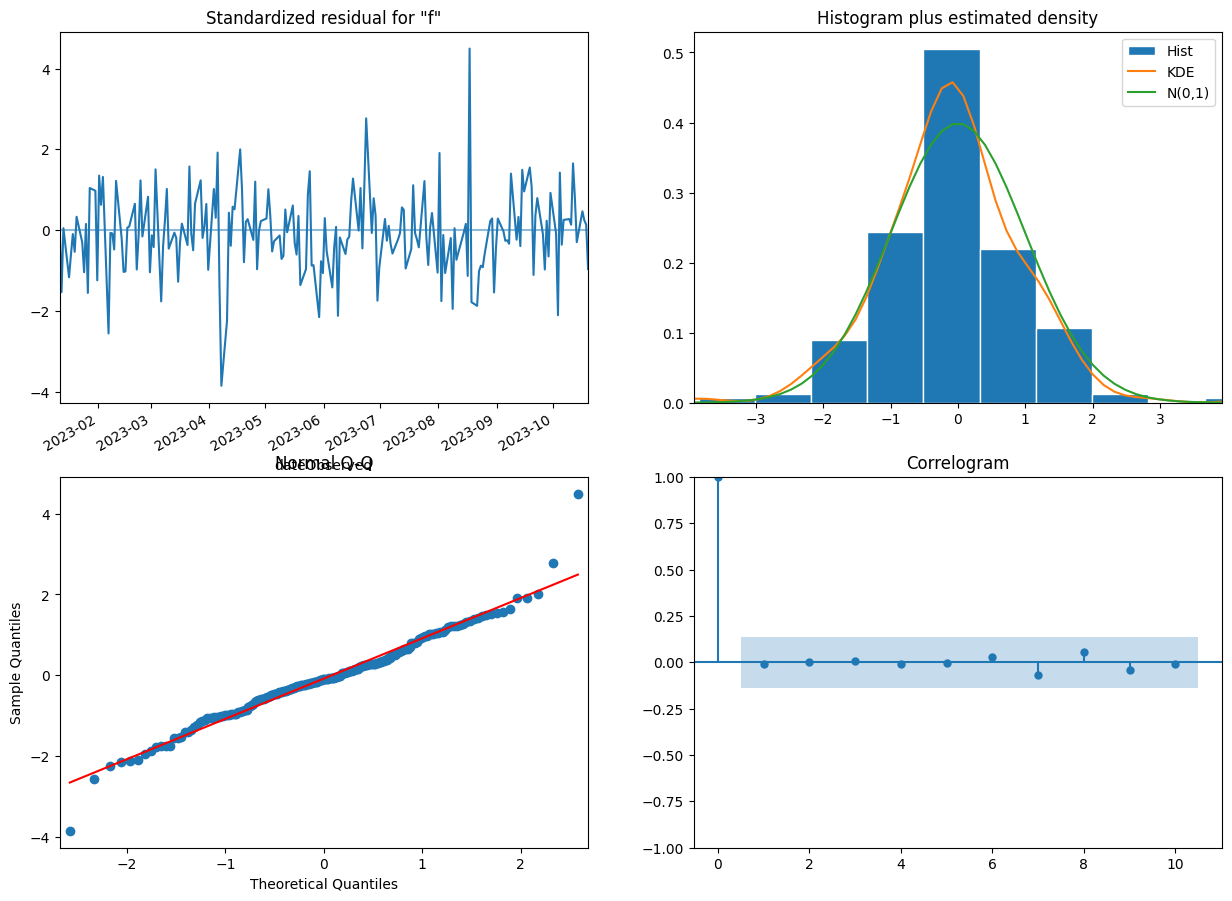

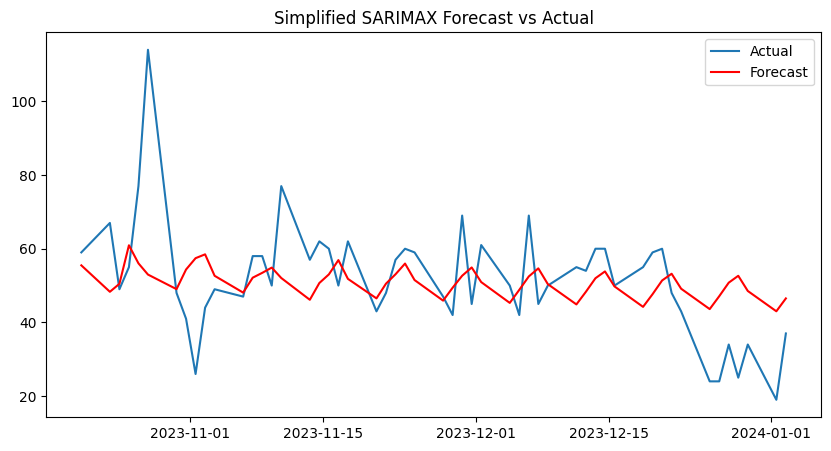

Mean Absolute Error (MAE): 10.85
Root Mean Squared Error (RMSE): 14.812
Mean Absolute Percentage Error (MAPE): 24.98%
Mean Absolute Scaled Error (MASE): 0.66%


In [88]:
# the sugested parameter of the grid search obtained result is not optimal:
#order=(2, 0,0), seasonal_order=(2,0,1,5) -> result :  (MASE): 0.83%, (MAE): 13.48, (RMSE): 17.979
# we evaluate the parameters based on PACF and ACF

model_BD1 = SARIMAX(data_train['filled_intensity'], 
                    order=(4,1,1),
                    seasonal_order=(4,1,1,5)
                   ) 
results_BD1 = model_BD1.fit(disp=None)
#print(results_BD1.summary())

# Check diagnostics again
results_BD1.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecast and compare to test set
forecast_BD1 = results_BD1.get_forecast(steps=len(data_test))
mean_forecast_BD1 = forecast_BD1.predicted_mean

plt.figure(figsize=(10, 5))
plt.plot(data_test.index, data_test['filled_intensity'], label='Actual')
plt.plot(mean_forecast_BD1.index, mean_forecast_BD1, color='red', label='Forecast')
plt.title('Simplified SARIMAX Forecast vs Actual')
plt.legend()
plt.show()

# evaluation 
actual = data_test['filled_intensity'] 
predicted = mean_forecast_BD1
training = data_train['filled_intensity']
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")


#### SARIMAX (with Exog)

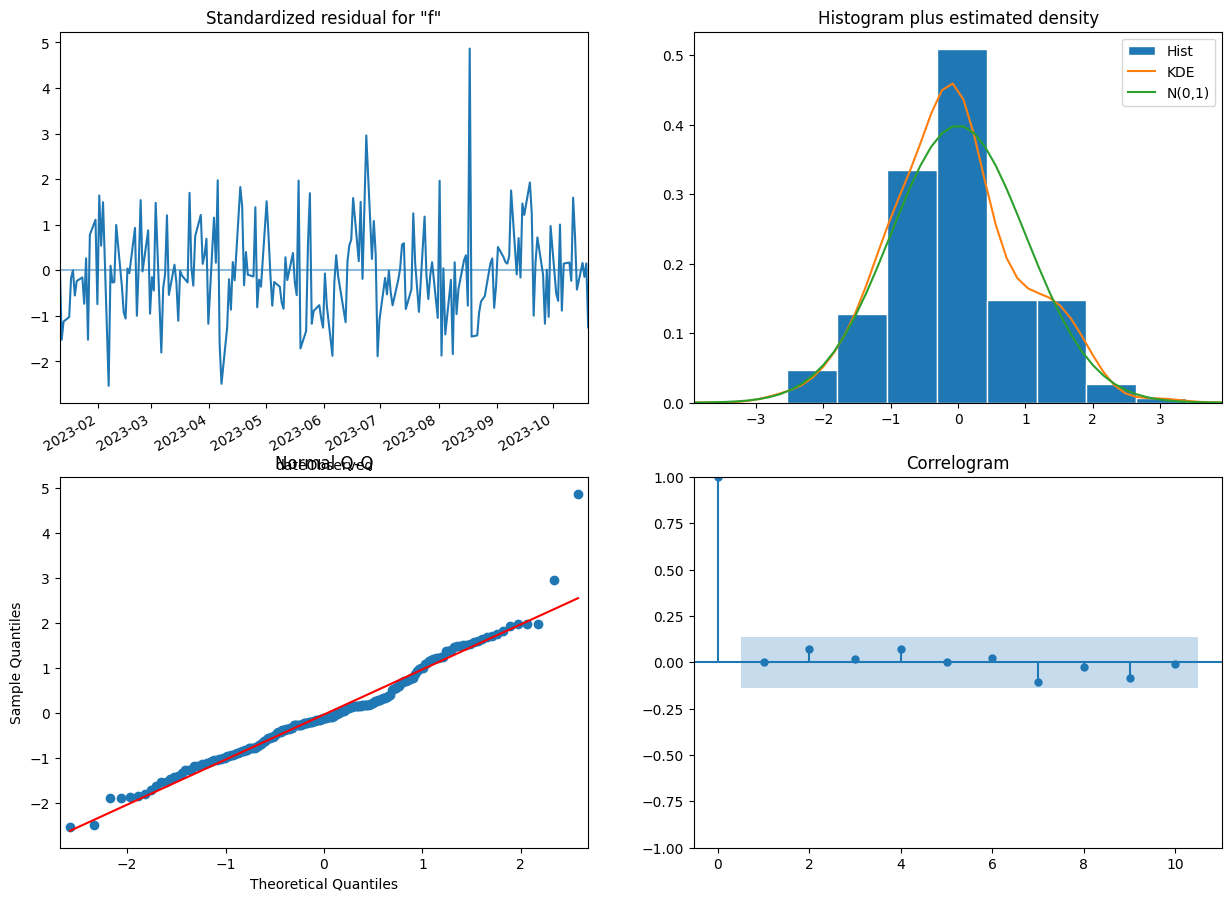

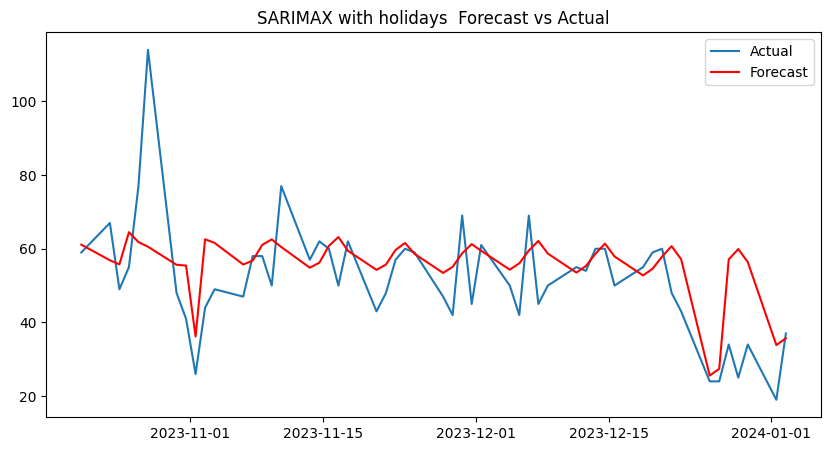

Mean Absolute Error (MAE): 9.48
Root Mean Squared Error (RMSE): 13.279
Mean Absolute Percentage Error (MAPE): 21.27%
Mean Absolute Scaled Error (MASE): 0.58%


In [89]:
exog_data_train = data_train[['is_holiday','dayofweek','month','hour','year']]
exog_data_test = data_test[['is_holiday','dayofweek','month','hour','year']]


model = SARIMAX(data_train['filled_intensity'], exog=exog_data_train, order=(4,1,1), seasonal_order=(4, 1,1, 5))
results = model.fit(disp=False)

# check diagnostics 

results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecast using the model
predictions = results.get_forecast(steps=len(data_test), exog=exog_data_test).predicted_mean


plt.figure(figsize=(10, 5))
plt.plot(data_test.index, data_test['filled_intensity'], label='Actual')
plt.plot(predictions.index, predictions, color='red', label='Forecast')
plt.title('SARIMAX with holidays  Forecast vs Actual')
plt.legend()
plt.show()

# evaluation 
actual = data_test['filled_intensity'] 
predicted = predictions
training = data_train['filled_intensity']
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")

## Frequcney Days 

In [90]:
data_mld.head(5)

,filled_intensity,year,month,day,date,hour,minute,dayofweek,is_weekend,lag_1,lag_2,is_holiday
dateObserved,,,,,,,,,,,,
2023-01-03 13:40:00+00:00,67.0,2023,1,3,2023-01-03,13,40,1,0,67.0,67.0,0
2023-01-04 13:40:00+00:00,62.0,2023,1,4,2023-01-04,13,40,2,0,64.0,60.0,0
2023-01-05 13:40:00+00:00,88.0,2023,1,5,2023-01-05,13,40,3,0,70.0,78.0,0
2023-01-06 13:40:00+00:00,51.0,2023,1,6,2023-01-06,13,40,4,0,44.0,40.0,1
2023-01-07 13:40:00+00:00,76.0,2023,1,7,2023-01-07,13,40,5,1,77.0,86.0,0


Train dates : 2023-01-03 13:40:00+00:00 --- 2023-10-21 13:40:00+00:00  (n=292)
Test dates  : 2023-10-22 13:40:00+00:00 --- 2024-01-02 13:40:00+00:00  (n=73)


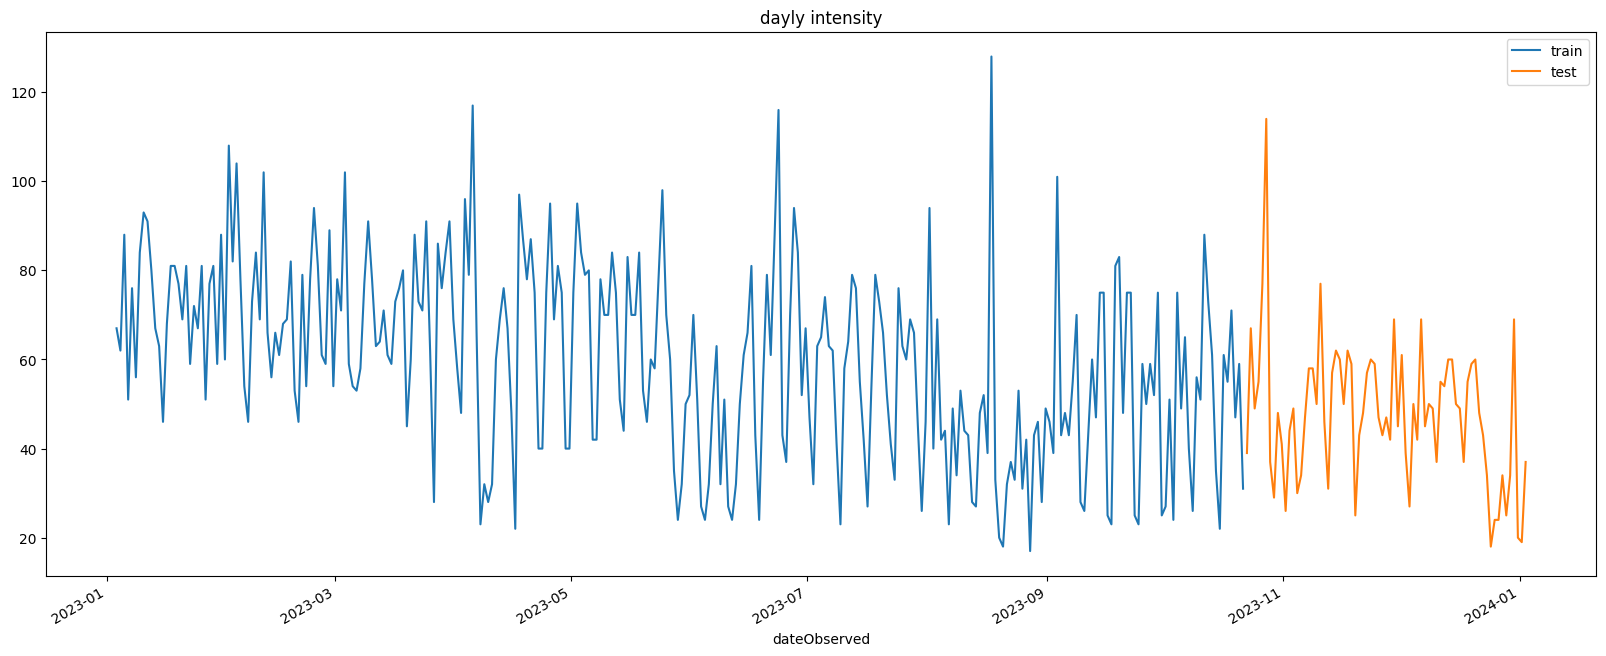

In [91]:
# Train-test dates
iloc_TrainEnd =int(data_mld.shape[0] - np.ceil(data_mld.shape[0]*0.2))
print(f"Train dates : {data_mld.index.min()} --- {data_mld.iloc[:iloc_TrainEnd].index.max()}  (n={len(data_mld.iloc[:iloc_TrainEnd])})")
print(f"Test dates  : {data_mld.iloc[iloc_TrainEnd:].index.min()} --- {data_mld.iloc[:].index.max()}  (n={len(data_mld.iloc[iloc_TrainEnd:])})")
data_train = data_mld.iloc[:iloc_TrainEnd]
data_test = data_mld.iloc[iloc_TrainEnd:]

fig, ax=plt.subplots()
data_train.plot(ax=ax, y='filled_intensity', label='train')  
data_test.plot(ax=ax, y='filled_intensity', label='test')   
ax.set_title('dayly intensity')
ax.legend();

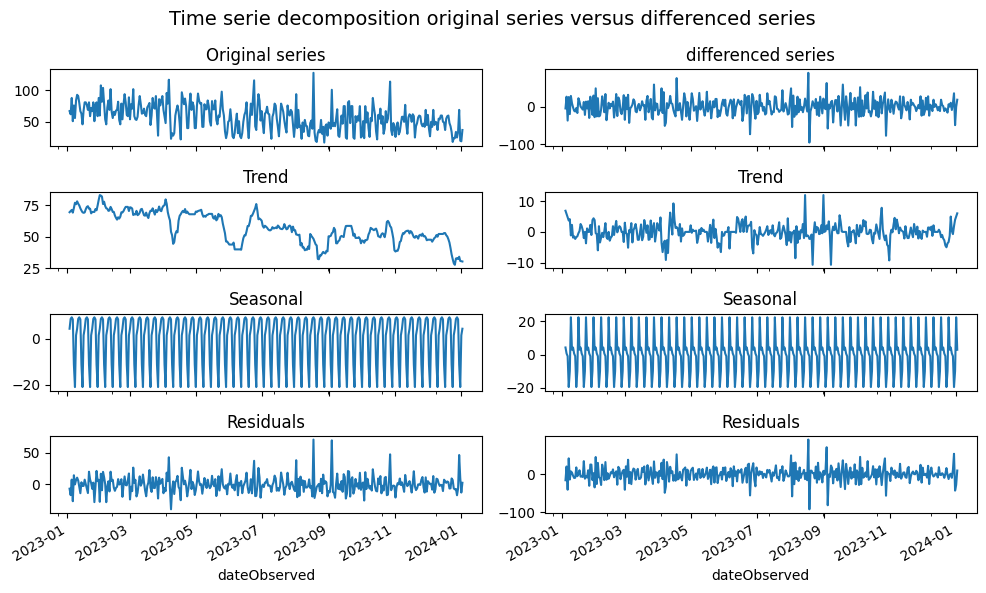

In [92]:
data_diff_1 = data_mld.diff().dropna()

res_decompose = seasonal_decompose(data_mld.filled_intensity, model='additive', extrapolate_trend='freq')
res_decompose2 = seasonal_decompose(data_diff_1.filled_intensity, model='additive', extrapolate_trend='freq')


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0,0])
axs[0,0].set_title('Original series')
res_decompose.trend.plot(ax=axs[1,0])
axs[1,0].set_title('Trend')
res_decompose.seasonal.plot(ax=axs[2,0])
axs[2,0].set_title('Seasonal')
res_decompose.resid.plot(ax=axs[3,0])
axs[3,0].set_title('Residuals')

res_decompose2.observed.plot(ax=axs[0,1])
axs[0,1].set_title('differenced series')
res_decompose2.trend.plot(ax=axs[1,1])
axs[1,1].set_title('Trend')
res_decompose2.seasonal.plot(ax=axs[2,1])
axs[2,1].set_title('Seasonal')
res_decompose2.resid.plot(ax=axs[3,1])
axs[3,1].set_title('Residuals')

fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();


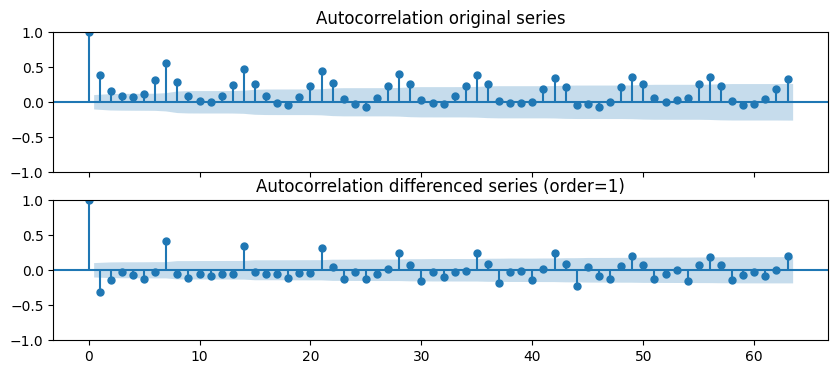

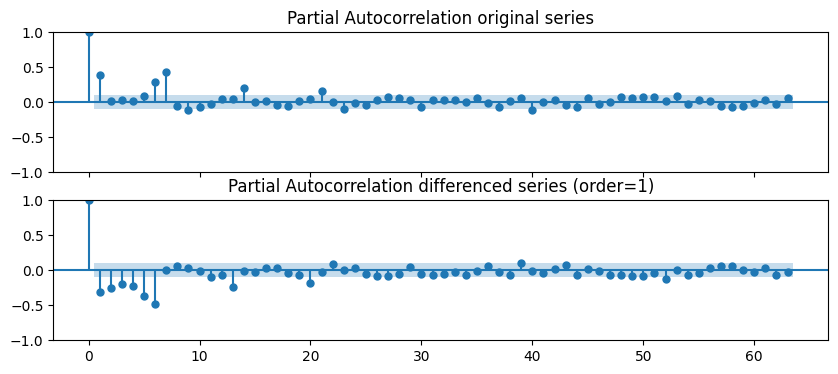

In [93]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
plot_acf(data_mld.filled_intensity, ax=axs[0], lags=63, alpha=0.05) 
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1.filled_intensity, ax=axs[1], lags=63, alpha=0.05)  
axs[1].set_title('Autocorrelation differenced series (order=1)');

# Partial autocorrelation plot for original and differenced series
# ==============================================================================

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
plot_pacf(data_mld.filled_intensity, ax=axs[0], lags=63, alpha=0.05) 
axs[0].set_title('Partial Autocorrelation original series')
plot_pacf(data_diff_1.filled_intensity, ax=axs[1], lags=63, alpha=0.05)  
axs[1].set_title('Partial Autocorrelation differenced series (order=1)');


### Grid Search

In [94]:
#Parameter Grids
p = q = range(1, 3)
d = [1]
P = D = Q = range(0, 2)  # Seasonal orders
S = [7]  # 7 for with weekly seasonality

param_grid = list(itertools.product(p, d, q, P, D, Q, S))

best_score = float('inf')
best_params = None

for params in param_grid:

    sarimax_model = sm.tsa.SARIMAX(data_train.filled_intensity, order=params[:3], seasonal_order=params[3:])
    sarimax_result = sarimax_model.fit(maxiter=500)
    
    
    validation_score = sarimax_result.aic
    print("Best parameters:", best_params)
    print("Best score:", best_score)
    
    # Update best score and parameters if current score is better
    if validation_score < best_score:
        best_score = validation_score
        best_params = params

print("Best parameters:", best_params)
print("Best score:", best_score)
#Best parameters: (0, 0, 1, 3, 0, 3, 7) Best score: 16.0

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.42861D+00    |proj g|=  1.55146D-01

At iterate    5    f=  4.37643D+00    |proj g|=  8.26147D-03

At iterate   10    f=  4.36540D+00    |proj g|=  3.91973D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   5.296D-07   4.365D+00
  F =   4.3653857306160448     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: None
Best score: inf
RUNNING THE L-BFGS-B CODE

     

 This problem is unconstrained.
 This problem is unconstrained.


Best parameters: (1, 1, 1, 0, 0, 0, 7)
Best score: 2555.38526667977
Best parameters: (1, 1, 1, 0, 0, 1, 7)
Best score: 2509.032864869055


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.30350D+00    |proj g|=  1.36432D-02

At iterate   10    f=  4.28262D+00    |proj g|=  2.25041D-03

At iterate   15    f=  4.28259D+00    |proj g|=  4.39009D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   4.390D-06   4.283D+00
  F =   4.2825905220360534     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.33051D+00    |proj g|=  4.50754D-02

At iter

 This problem is unconstrained.


Best parameters: (1, 1, 1, 0, 1, 1, 7)
Best score: 2408.6931712111855
NG THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.34526D+00    |proj g|=  1.56248D-01

At iterate    5    f=  4.26431D+00    |proj g|=  2.77909D-02

At iterate   10    f=  4.24440D+00    |proj g|=  6.35771D-03

At iterate   15    f=  4.24195D+00    |proj g|=  8.05162D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   1.218D-05   4.242D+00
  F =   4.2419517352860314     

CONV

 This problem is unconstrained.



At iterate   20    f=  4.19527D+00    |proj g|=  3.65090D-03

At iterate   25    f=  4.19519D+00    |proj g|=  3.27578D-04

At iterate   30    f=  4.19518D+00    |proj g|=  1.23912D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     37      1     0     0   2.712D-06   4.195D+00
  F =   4.1951806392897817     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 1, 0, 1, 1, 7)
Best score: 2408.6931712111855
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  4.14369D+00    |proj g|=  4.93829D-02

At iterate   10    f=  4.09163D+00    |proj g|=  2.45411D-03

At iterate   15    f=  4.09161D+00    |proj g|=  1.23077D-03

At iterate   20    f=  4.09150D+00    |proj g|=  4.50568D-03

At iterate   25    f=  4.09135D+00    |proj g|=  1.07407D-03

At iterate   30    f=  4.09134D+00    |proj g|=  1.43774D-04

At iterate   35    f=  4.09134D+00    |proj g|=  1.77124D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     47      1     0     0   8.057D-05   4.091D+00
  F =   4.0913371161687753     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.67339D+00    |proj g|=  7.60344D-01

At iterate    5    f=  4.30348D+00    |proj g|=  3.24852D-02

At iterate   10    f=  4.29595D+00    |proj g|=  1.31535D-02

At iterate   15    f=  4.28428D+00    |proj g|=  1.54224D-02

At iterate   20    f=  4.28354D+00    |proj g|=  1.01017D-02

At iterate   25    f=  4.28253D+00    |proj g|=  1.61595D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  4.28282D+00    |proj g|=  1.77329D-02

At iterate   10    f=  4.27994D+00    |proj g|=  6.34599D-03

At iterate   15    f=  4.27890D+00    |proj g|=  1.99079D-03

At iterate   20    f=  4.27730D+00    |proj g|=  8.23941D-04

At iterate   25    f=  4.27710D+00    |proj g|=  5.61506D-04

At iterate   30    f=  4.27707D+00    |proj g|=  4.91187D-05

At iterate   35    f=  4.27707D+00    |proj g|=  1.89774D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     42      1     0     0   9.754D-06   4.277D+00
  F =   4.2770713057913055     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  4.15487D+00    |proj g|=  4.02554D-02

At iterate   10    f=  4.11135D+00    |proj g|=  1.53190D-02

At iterate   15    f=  4.10449D+00    |proj g|=  2.16512D-03

At iterate   20    f=  4.10390D+00    |proj g|=  9.16654D-03

At iterate   25    f=  4.10300D+00    |proj g|=  4.50593D-03

At iterate   30    f=  4.10136D+00    |proj g|=  4.24363D-04

At iterate   35    f=  4.10124D+00    |proj g|=  2.74274D-04

At iterate   40    f=  4.10122D+00    |proj g|=  2.88576D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     63      1     0     0   2.293D-05   4.101D+00
  F =   4.10122195636

 This problem is unconstrained.


Best parameters: (1, 1, 1, 1, 1, 1, 7)
Best score: 2399.340875842565
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.63533D+00    |proj g|=  7.86168D-01

At iterate    5    f=  4.27408D+00    |proj g|=  4.26861D-02

At iterate   10    f=  4.25751D+00    |proj g|=  2.35137D-02

At iterate   15    f=  4.24719D+00    |proj g|=  7.91388D-03

At iterate   20    f=  4.24206D+00    |proj g|=  1.15237D-02

At iterate   25    f=  4.24129D+00    |proj g|=  1.37208D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Sk

 This problem is unconstrained.


6.548D-06   4.241D+00
  F =   4.2412922840199210     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61673D+00    |proj g|=  7.36465D-01

At iterate    5    f=  4.24385D+00    |proj g|=  3.00945D-02

At iterate   10    f=  4.20884D+00    |proj g|=  1.40064D-02

At iterate   15    f=  4.20276D+00    |proj g|=  1.20595D-02

At iterate   20    f=  4.20217D+00    |proj g|=  4.13546D-03

At iterate   25    f=  4.19747D+00    |proj g|=  7.06107D-03

At iterate   30    f=  4.19197D+00    |proj g|=  1.68308D-03

At iterate   35    f=  4.19131D+00    |proj g|=  3.59814D-04

At iterate   40    f=  4.19129D+00    |proj g|=  1.40050D-03

At iterate   45    f=  4.19117D+00    |proj g|=  1.69747D-03

At iterate   50    f=  4.18808D+00    |proj g|=  9.64200D-03

At iterate   55    f=  4.18676D+00

 This problem is unconstrained.



At iterate   10    f=  4.19186D+00    |proj g|=  8.44479D-03

At iterate   15    f=  4.19138D+00    |proj g|=  8.27172D-04

At iterate   20    f=  4.19092D+00    |proj g|=  1.12109D-02

At iterate   25    f=  4.18825D+00    |proj g|=  1.67128D-03

At iterate   30    f=  4.18801D+00    |proj g|=  1.42068D-03

At iterate   35    f=  4.18797D+00    |proj g|=  2.43672D-04

At iterate   40    f=  4.18797D+00    |proj g|=  2.42908D-04

At iterate   45    f=  4.18797D+00    |proj g|=  1.47570D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     53      1     0     0   5.710D-06   4.188D+00
  F =   4.18796483934

 This problem is unconstrained.



At iterate    5    f=  4.16039D+00    |proj g|=  3.23085D-02

At iterate   10    f=  4.10430D+00    |proj g|=  2.62271D-02

At iterate   15    f=  4.08445D+00    |proj g|=  3.35853D-03

At iterate   20    f=  4.08427D+00    |proj g|=  6.87475D-03

At iterate   25    f=  4.08318D+00    |proj g|=  2.07560D-03

At iterate   30    f=  4.08301D+00    |proj g|=  5.49138D-04

At iterate   35    f=  4.08300D+00    |proj g|=  9.80445D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     58      1     0     0   5.013D-04   4.083D+00
  F =   4.0829957215438579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  4.36394D+00    |proj g|=  6.73812D-03

At iterate   15    f=  4.35978D+00    |proj g|=  1.14423D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     21      1     0     0   4.166D-06   4.360D+00
  F =   4.3597029979330051     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 2, 1, 1, 1, 7)
Best score: 2396.469501381613
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.37282D+00    |proj g|=  1.48708D-01



 This problem is unconstrained.



At iterate   15    f=  4.28458D+00    |proj g|=  4.16222D-02

At iterate   20    f=  4.28249D+00    |proj g|=  1.86502D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     23      1     0     0   2.298D-05   4.282D+00
  F =   4.2824929155221962     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 2, 1, 1, 1, 7)
Best score: 2396.469501381613
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.33615D+00    |proj g|=  4.26926D-02



 This problem is unconstrained.



At iterate   15    f=  4.27851D+00    |proj g|=  8.75805D-04

At iterate   20    f=  4.27813D+00    |proj g|=  7.60150D-03

At iterate   25    f=  4.27795D+00    |proj g|=  3.27630D-03

At iterate   30    f=  4.27793D+00    |proj g|=  4.21471D-04

At iterate   35    f=  4.27792D+00    |proj g|=  6.43143D-05

At iterate   40    f=  4.27792D+00    |proj g|=  9.21094D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     45      1     0     0   9.211D-06   4.278D+00
  F =   4.2779227685112495     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 2, 1, 1, 1, 7)
Best score: 

 This problem is unconstrained.



At iterate   10    f=  4.11124D+00    |proj g|=  2.82023D-04

At iterate   15    f=  4.11045D+00    |proj g|=  9.07381D-03

At iterate   20    f=  4.11031D+00    |proj g|=  3.80080D-03

At iterate   25    f=  4.10973D+00    |proj g|=  1.30353D-02

At iterate   30    f=  4.10951D+00    |proj g|=  1.44543D-03

At iterate   35    f=  4.10915D+00    |proj g|=  5.95701D-03

At iterate   40    f=  4.10885D+00    |proj g|=  1.93611D-03

At iterate   45    f=  4.10879D+00    |proj g|=  5.31263D-04

At iterate   50    f=  4.10878D+00    |proj g|=  6.24981D-04

At iterate   55    f=  4.10878D+00    |proj g|=  4.14372D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.27836D+00    |proj g|=  6.61452D-02

At iterate   10    f=  4.24208D+00    |proj g|=  1.55117D-03

At iterate   15    f=  4.24141D+00    |proj g|=  9.87401D-03

At iterate   20    f=  4.24126D+00    |proj g|=  2.02922D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   2.029D-06   4.241D+00
  F =   4.2412609151767464     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 2, 1, 1, 1, 7)
Best score: 2396.469501381613
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =      

 This problem is unconstrained.



At iterate   15    f=  4.19403D+00    |proj g|=  2.26531D-03

At iterate   20    f=  4.19320D+00    |proj g|=  5.80962D-03

At iterate   25    f=  4.19315D+00    |proj g|=  1.03292D-03

At iterate   30    f=  4.19300D+00    |proj g|=  3.31364D-03

At iterate   35    f=  4.19292D+00    |proj g|=  2.88604D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     44      1     0     0   2.634D-06   4.193D+00
  F =   4.1929193079268972     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 2, 1, 1, 1, 7)
Best score: 2396.469501381613
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate   15    f=  4.19741D+00    |proj g|=  1.70761D-02

At iterate   20    f=  4.19330D+00    |proj g|=  4.70171D-03

At iterate   25    f=  4.19281D+00    |proj g|=  1.58405D-03

At iterate   30    f=  4.19274D+00    |proj g|=  1.00035D-03

At iterate   35    f=  4.19273D+00    |proj g|=  6.14233D-05

At iterate   40    f=  4.19273D+00    |proj g|=  1.24208D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     50      1     0     0   7.591D-05   4.193D+00
  F =   4.1927309322808073     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 2, 1, 1, 1, 7)
Best score: 

 This problem is unconstrained.



At iterate   15    f=  4.08617D+00    |proj g|=  1.55830D-04

At iterate   20    f=  4.08615D+00    |proj g|=  3.79697D-03

At iterate   25    f=  4.08595D+00    |proj g|=  1.85340D-03

At iterate   30    f=  4.08592D+00    |proj g|=  4.81004D-04

At iterate   35    f=  4.08591D+00    |proj g|=  1.07455D-04

At iterate   40    f=  4.08591D+00    |proj g|=  1.16638D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     50      1     0     0   2.597D-04   4.086D+00
  F =   4.0859072444121303     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 2, 1, 1, 1, 7)
Best score: 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.70344D+00    |proj g|=  5.83758D-01

At iterate    5    f=  4.37526D+00    |proj g|=  2.32980D-02

At iterate   10    f=  4.36817D+00    |proj g|=  8.59767D-03

At iterate   15    f=  4.36379D+00    |proj g|=  1.12176D-03

At iterate   20    f=  4.36378D+00    |proj g|=  5.79616D-05

At iterate   25    f=  4.36378D+00    |proj g|=  1.77232D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     30      1     0     0   

 This problem is unconstrained.



At iterate   20    f=  4.27922D+00    |proj g|=  6.00087D-04

At iterate   25    f=  4.27921D+00    |proj g|=  1.08806D-04

At iterate   30    f=  4.27921D+00    |proj g|=  3.62581D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     35      1     0     0   2.889D-06   4.279D+00
  F =   4.2792072009309070     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 2, 1, 1, 1, 7)
Best score: 2396.469501381613
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.



At iterate   10    f=  4.27794D+00    |proj g|=  2.00963D-02

At iterate   15    f=  4.27362D+00    |proj g|=  3.85716D-03

At iterate   20    f=  4.27346D+00    |proj g|=  1.22714D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   1.216D-05   4.273D+00
  F =   4.2734589804854641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 2, 1, 1, 1, 7)
Best score: 2396.469501381613
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.



At iterate    5    f=  4.14950D+00    |proj g|=  5.39363D-02

At iterate   10    f=  4.11788D+00    |proj g|=  1.62449D-02

At iterate   15    f=  4.11630D+00    |proj g|=  4.01236D-03

At iterate   20    f=  4.11440D+00    |proj g|=  1.43506D-02

At iterate   25    f=  4.11343D+00    |proj g|=  3.12263D-02

At iterate   30    f=  4.10758D+00    |proj g|=  4.68413D-03

At iterate   35    f=  4.10750D+00    |proj g|=  9.16319D-04

At iterate   40    f=  4.10429D+00    |proj g|=  1.80407D-02

At iterate   45    f=  4.10234D+00    |proj g|=  5.55006D-03

At iterate   50    f=  4.10136D+00    |proj g|=  1.67362D-03

At iterate   55    f=  4.10125D+00    |proj g|=  3.38228D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

 This problem is unconstrained.



At iterate   20    f=  4.23746D+00    |proj g|=  1.31316D-03

At iterate   25    f=  4.23728D+00    |proj g|=  1.63106D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     28      1     0     0   5.573D-06   4.237D+00
  F =   4.2372835578202679     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 2, 1, 1, 1, 7)
Best score: 2396.469501381613
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.53528D+00    |proj g|=  5.99591D-01



 This problem is unconstrained.



At iterate   10    f=  4.20131D+00    |proj g|=  2.59777D-02

At iterate   15    f=  4.19801D+00    |proj g|=  5.65176D-03

At iterate   20    f=  4.19726D+00    |proj g|=  8.20811D-05

At iterate   25    f=  4.19726D+00    |proj g|=  1.80695D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     30      1     0     0   4.825D-06   4.197D+00
  F =   4.1972563608345643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Best parameters: (1, 1, 2, 1, 1, 1, 7)
Best score: 2396.469501381613
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =      

 This problem is unconstrained.



At iterate   15    f=  4.19540D+00    |proj g|=  1.37413D-03

At iterate   20    f=  4.19498D+00    |proj g|=  1.50280D-03

At iterate   25    f=  4.19413D+00    |proj g|=  3.11938D-03

At iterate   30    f=  4.19410D+00    |proj g|=  1.61544D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     37      1     0     0   1.615D-05   4.194D+00
  F =   4.1941026412492270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Best parameters: (1, 1, 2, 1, 1, 1, 7)
Best score: 2396.469501381613
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =      

 This problem is unconstrained.



At iterate    5    f=  4.15381D+00    |proj g|=  2.05851D-02

At iterate   10    f=  4.09897D+00    |proj g|=  2.39126D-02

At iterate   15    f=  4.08980D+00    |proj g|=  1.28060D-03

At iterate   20    f=  4.08960D+00    |proj g|=  2.08768D-03

At iterate   25    f=  4.08959D+00    |proj g|=  6.35542D-05

At iterate   30    f=  4.08959D+00    |proj g|=  1.15119D-03

At iterate   35    f=  4.08955D+00    |proj g|=  3.69968D-03

At iterate   40    f=  4.08953D+00    |proj g|=  8.27832D-04

At iterate   45    f=  4.08951D+00    |proj g|=  7.13540D-04

At iterate   50    f=  4.08949D+00    |proj g|=  3.17173D-04

At iterate   55    f=  4.08949D+00    |proj g|=  6.01817D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   

#### SARIMA (without Exog)

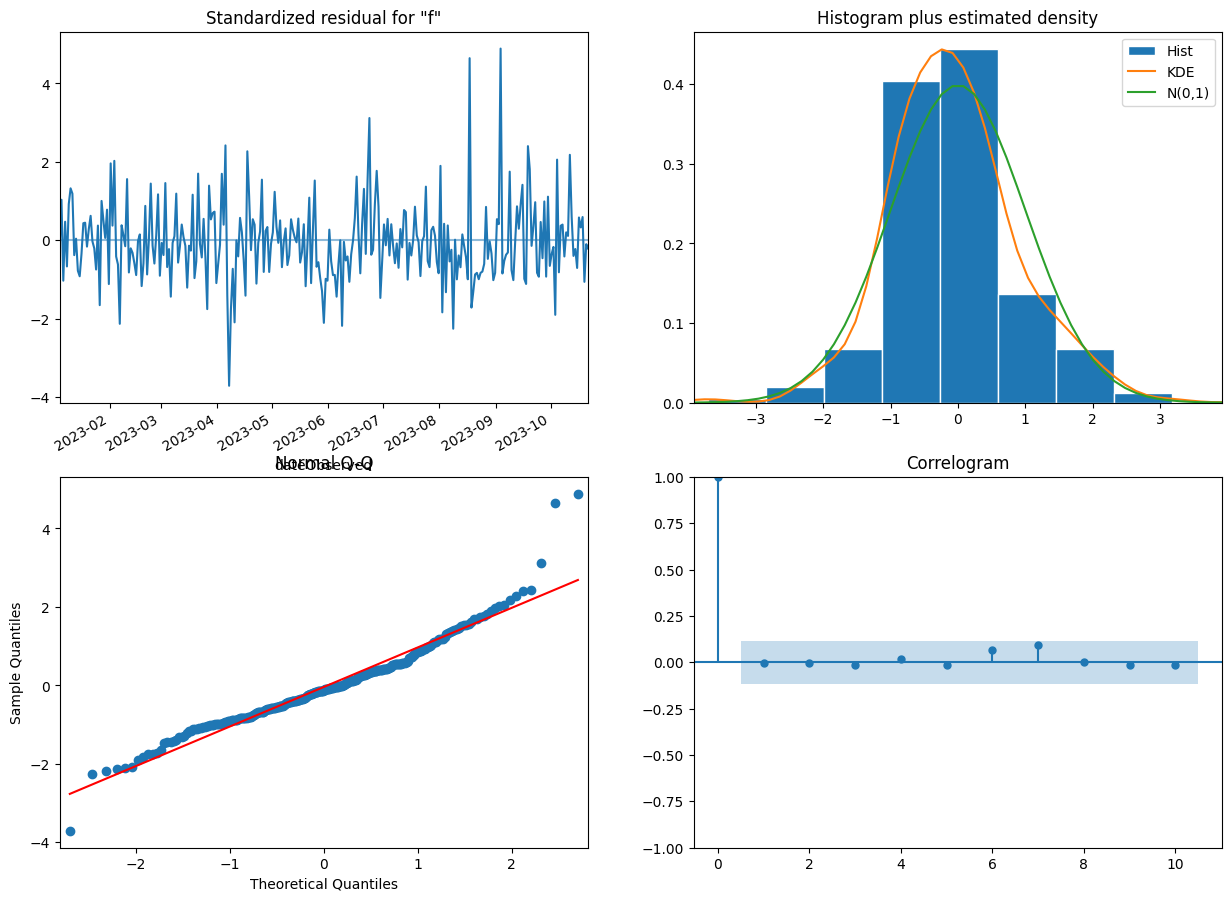

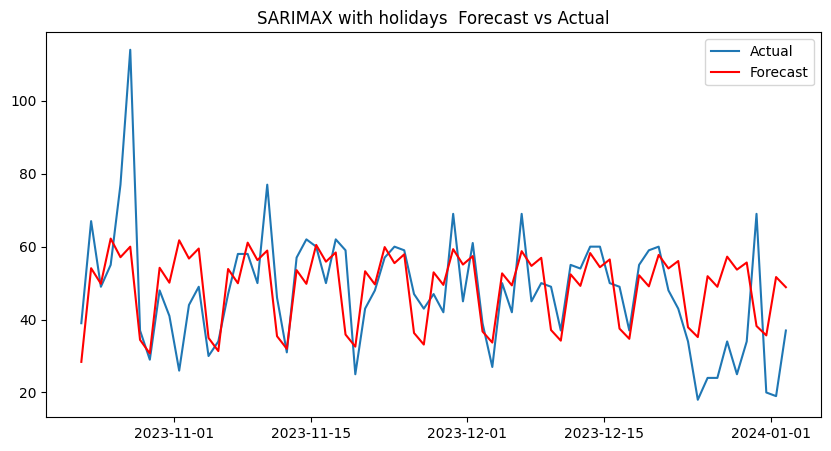

Mean Absolute Error (MAE): 10.24
Root Mean Squared Error (RMSE): 14.056
Mean Absolute Percentage Error (MAPE): 26.55%
Mean Absolute Scaled Error (MASE): 0.55%


In [95]:
# order=(1,1,2), seasonal_order=(1, 1,1, 7)) -> MASE= 0.63% (MAE): 11.79 (RMSE): 15.494

model = SARIMAX(data_train['filled_intensity'], order=(3,1,2), seasonal_order=(1,0,1, 7))
results = model.fit(disp=False)
#order=(3,1,1), seasonal_order=(1,0,1, 7))
# check diagnostics 

results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecast using the model
predictions = results.get_forecast(steps=len(data_test), exog=exog_data_test).predicted_mean


plt.figure(figsize=(10, 5))
plt.plot(data_test.index, data_test['filled_intensity'], label='Actual')
plt.plot(predictions.index, predictions, color='red', label='Forecast')
plt.title('SARIMAX with holidays  Forecast vs Actual')
plt.legend()
plt.show()

# evaluation 
actual = data_test['filled_intensity'] 
predicted = predictions
training = data_train['filled_intensity']
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")

#### SARIMA (with all Exog)

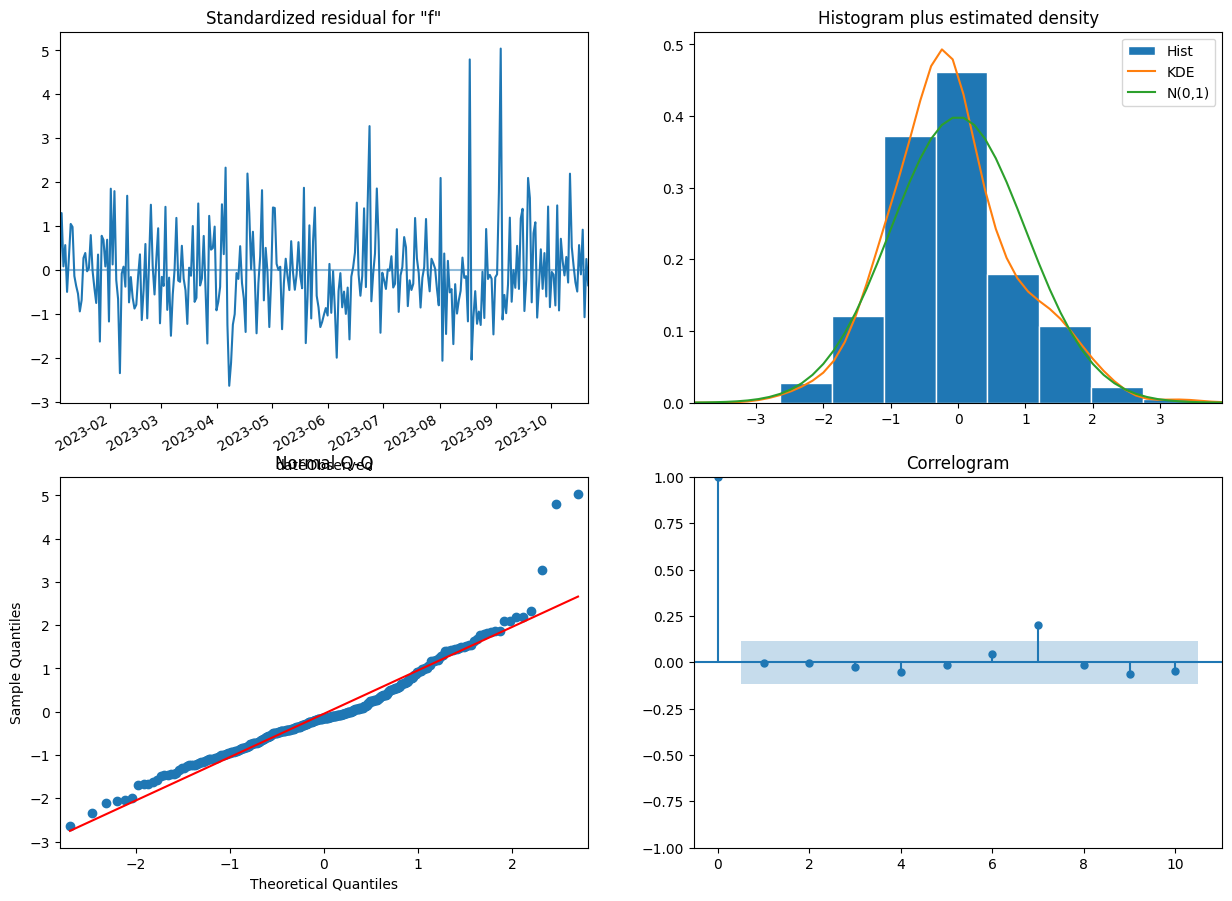

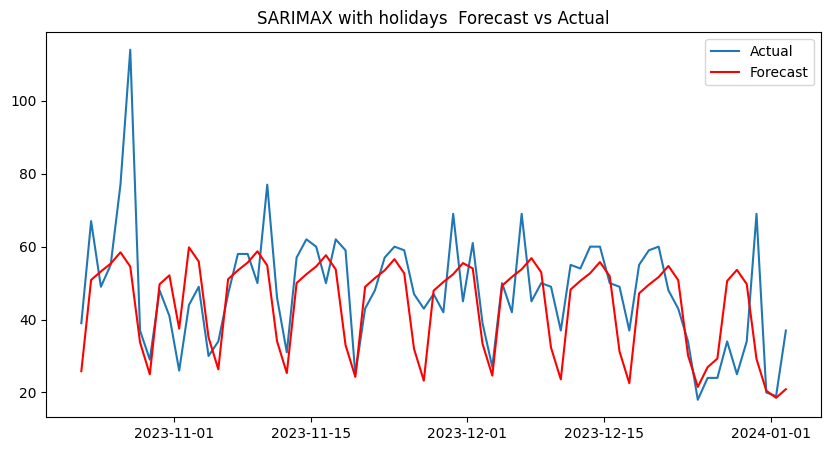

Mean Absolute Error (MAE): 9.74
Root Mean Squared Error (RMSE): 13.441
Mean Absolute Percentage Error (MAPE): 20.57%
Mean Absolute Scaled Error (MASE): 0.52%


In [96]:
exog_data_train = data_train[['is_holiday','dayofweek','month','hour','year']]
exog_data_test = data_test[['is_holiday','dayofweek','month','hour','year']]


model = SARIMAX(data_train['filled_intensity'], exog=exog_data_train, order=(3,1,2), seasonal_order=(1,0,1, 7))
results = model.fit(disp=False)
#order=(3,1,1), seasonal_order=(1,0,1, 7)
#order=(3,1,2), seasonal_order=(1,0,1, 7)
# order=(6,1,1), seasonal_order=(4, 1,1, 7)


# check diagnostics 

results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecast using the model
predictions = results.get_forecast(steps=len(data_test), exog=exog_data_test).predicted_mean


plt.figure(figsize=(10, 5))
plt.plot(data_test.index, data_test['filled_intensity'], label='Actual')
plt.plot(predictions.index, predictions, color='red', label='Forecast')
plt.title('SARIMAX with holidays  Forecast vs Actual')
plt.legend()
plt.show()

# evaluation 
actual = data_test['filled_intensity'] 
predicted = predictions
training = data_train['filled_intensity']
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")

#### SARIMA (with one Exog) : BEST RESULT

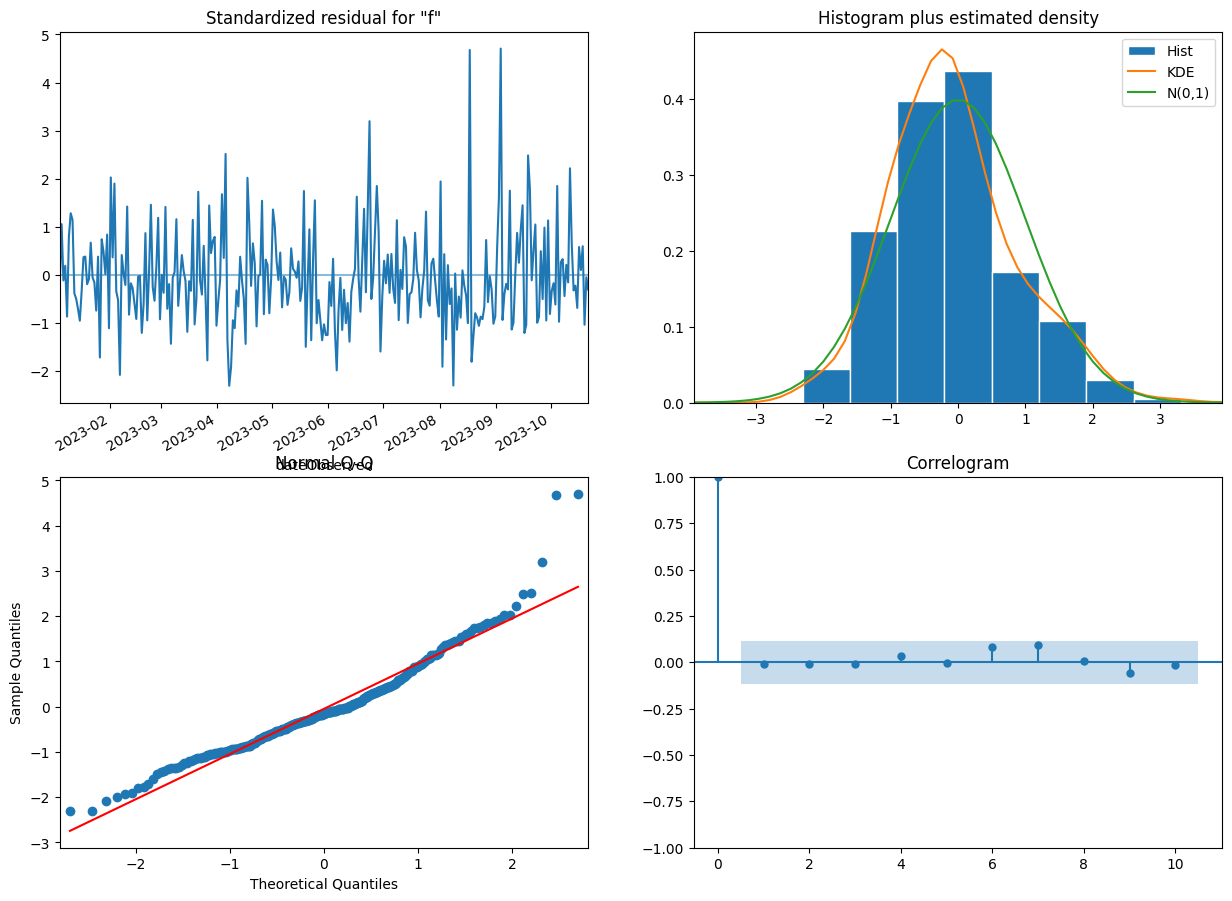

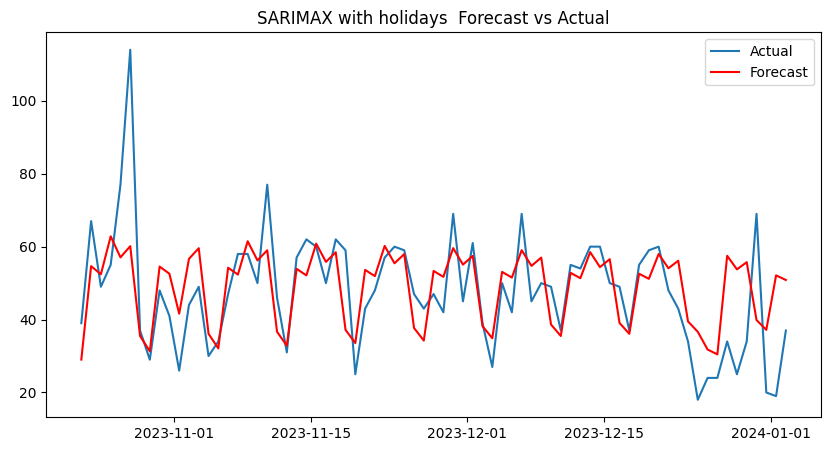

Mean Absolute Error (MAE): 9.43
Root Mean Squared Error (RMSE): 12.835
Mean Absolute Percentage Error (MAPE): 23.60%
Mean Absolute Scaled Error (MASE): 0.50%


In [97]:
exog_data_train = data_train[['is_holiday']]
exog_data_test = data_test[['is_holiday']]


model = SARIMAX(data_train['filled_intensity'], exog=exog_data_train, order=(3,1,2), seasonal_order=(1,0,1, 7))
results = model.fit(disp=False)

# check diagnostics 

results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecast using the model
predictions = results.get_forecast(steps=len(data_test), exog=exog_data_test).predicted_mean


plt.figure(figsize=(10, 5))
plt.plot(data_test.index, data_test['filled_intensity'], label='Actual')
plt.plot(predictions.index, predictions, color='red', label='Forecast')
plt.title('SARIMAX with holidays  Forecast vs Actual')
plt.legend()
plt.show()

# evaluation 
actual = data_test['filled_intensity'] 
predicted = predictions
training = data_train['filled_intensity']
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")

## Prophet

In [98]:
holidayProphet = pd.DataFrame({
  'holiday': 'public_holiday',
  'ds': pd.to_datetime(['2023-01-01 13:40:00+00:00', '2023-01-06 13:40:00+00:00', '2023-04-07 13:40:00+00:00', '2023-04-10 13:40:00+00:00', '2023-05-01 13:40:00+00:00',
                        '2023-05-18 13:40:00+00:00', '2023-05-29 13:40:00+00:00','2023-06-03 13:40:00+00:00', '2023-06-08 13:40:00+00:00','2023-07-08 13:40:00+00:00','2023-09-02 13:40:00+00:00','2023-10-03 13:40:00+00:00', '2023-11-01 13:40:00+00:00',
                        '2023-12-25 13:40:00+00:00', '2023-12-26 13:40:00+00:00']),
  'lower_window': 0,
  'upper_window': 1,
})


In [99]:

data_mld = data_ml.asfreq('D') 

end = data_mld.index.max() - pd.DateOffset(months=1)
iloc_End = data_mld.index.get_loc(end)

data_prophet = data_mld.iloc[:iloc_End]
# Train-test dates

testEnd = data_prophet.index.max() - pd.DateOffset(months=1)
iloc_train = data_prophet.index.get_loc(testEnd)

# Define training and testing datasets
data_trainp = data_prophet.iloc[:iloc_train]
data_testp = data_prophet.iloc[iloc_train:]

# Print training and testing periods
print(f"Train dates : {data_trainp.index.min()} --- {data_trainp.index.max()}  (n={len(data_trainp)})")
print(f"Test dates  : {data_testp.index.min()} --- {data_testp.index.max()}  (n={len(data_testp)})")

Train dates : 2023-01-03 13:40:00+00:00 --- 2023-10-31 13:40:00+00:00  (n=302)
Test dates  : 2023-11-01 13:40:00+00:00 --- 2023-12-01 13:40:00+00:00  (n=31)


### Defult 

In [100]:
# prepearing for model 
data_prophet = data_prophet.reset_index()
data_prophet = data_prophet.rename(columns ={'dateObserved': 'ds', 'filled_intensity':'y'})
data_trainp = data_trainp.reset_index()
data_trainp = data_trainp.rename(columns ={'dateObserved': 'ds', 'filled_intensity':'y'})
data_trainp['ds'] = data_trainp['ds'].dt.tz_localize(None)

data_testp = data_testp.reset_index()
data_testp = data_testp.rename(columns ={'dateObserved': 'ds', 'filled_intensity':'y'})
data_testp['ds'] = data_testp['ds'].dt.tz_localize(None)
forcast_df = data_testp.drop(columns ='y')

holidays= pd.DataFrame({
  'holiday': 'public_holiday',
  'ds': pd.to_datetime(['2023-05-29 13:40:00+0000'
                        ]),
  'lower_window': 0,
  'upper_window': 1,
})


prophet    INFO  Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: /var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/b_9fk8di.json
cmdstanpy  DEBUG input tempfile: /var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/_5ffkbwt.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32511', 'data', 'file=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/b_9fk8di.json', 'init=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/_5ffkbwt.json', 'output', 'file=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/prophet_model5iz1py2w/proph

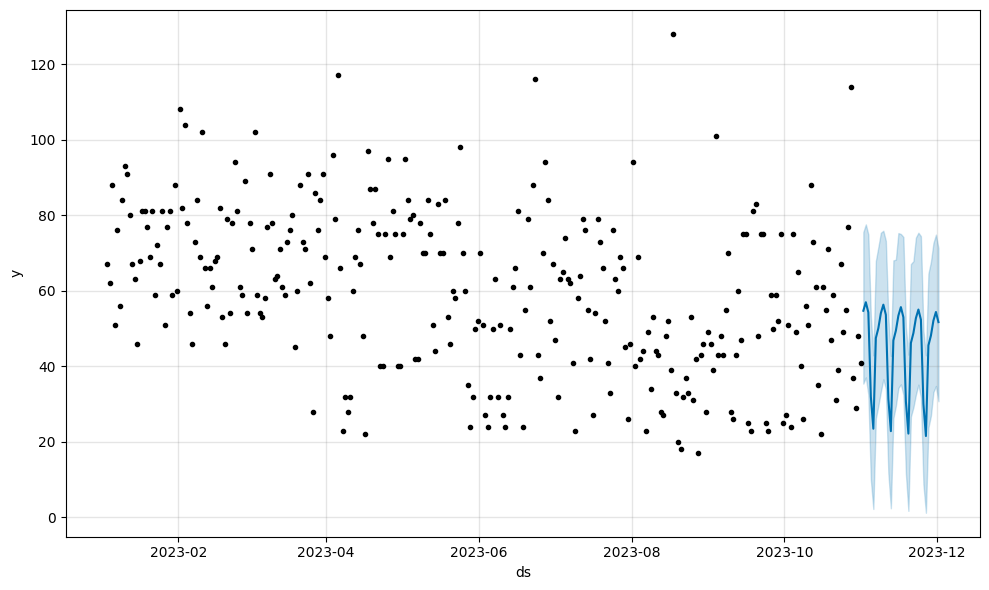

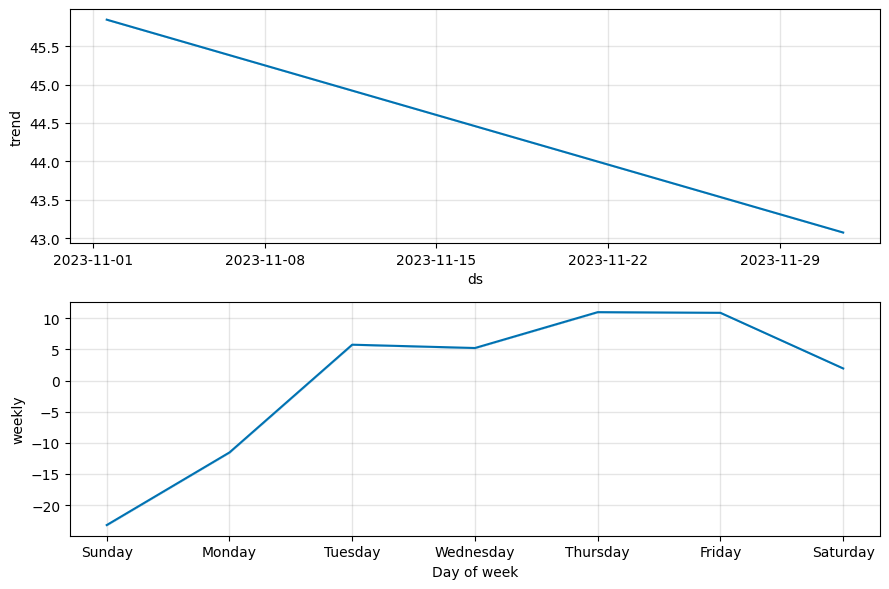

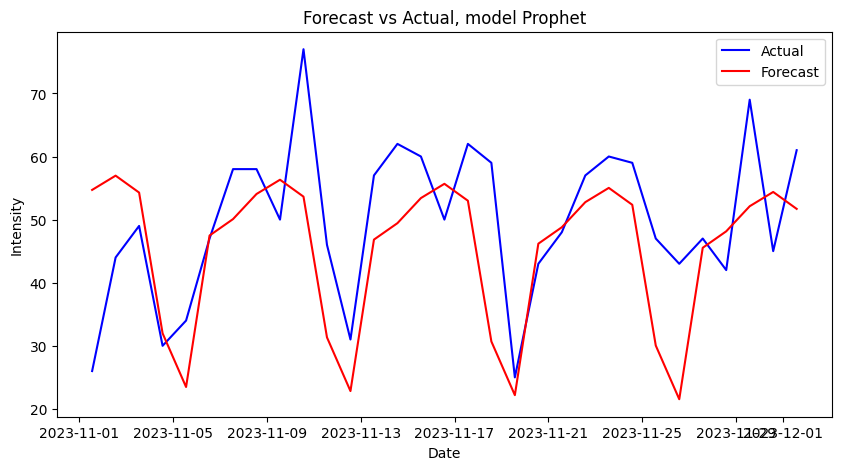

Mean Absolute Error (MAE): 9.71
Root Mean Squared Error (RMSE): 12.252
Mean Absolute Percentage Error (MAPE): 20.82%
Mean Absolute Scaled Error (MASE): 0.52%


In [101]:
model = Prophet()

model.fit(data_trainp)

forecast2 = model.predict(forcast_df)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = model.plot(forecast2)
fig2 = model.plot_components(forecast2)



plt.figure(figsize=(10, 5))
plt.plot(data_testp['ds'], data_testp['y'], label='Actual', color='blue')
plt.plot(forecast2['ds'], forecast2['yhat'], color='red', label='Forecast')
plt.title('Forecast vs Actual, model Prophet')
plt.xlabel('Date') 
plt.ylabel('Intensity') 
plt.legend()
plt.show()

# evaluation 
actual = data_testp['y'] 
predicted = forecast2['yhat']
training = data_trainp['y']

mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")

### Tuned

In [102]:
holidayProphet_list = holidayProphet.ds

def grid_search_prophet(args_list):
    global data_trainp, data_testp

    params_evaluated = []
    results = []

    for params in args_list:
        try:
            model = Prophet(**params)
            model.fit(data_trainp)
            future = model.make_future_dataframe(periods=len(data_testp), freq='D')
            forecast = model.predict(future)
            predictions_tuned = forecast.tail(len(data_testp))
            error = mape(data_testp['y'], predictions_tuned['yhat'])

            params_evaluated.append(params)
            results.append(error)
        except:
            params_evaluated.append(params)
            results.append(25.0)# Giving high loss for exceptions regions of spaces

    return params_evaluated, results

param_space = dict(
                   n_changepoints  = range(0,10, 5),
                   changepoint_range  = uniform(0.5, 0.5),
                   yearly_seasonality = [True, False],
                   weekly_seasonality = [True, False],
                   daily_seasonality = [True, False],
                   seasonality_mode = ['additive', 'multiplicative'],
                   seasonality_prior_scale=uniform(5.0, 15.0),
                   changepoint_prior_scale=uniform(0.0, 0.1),
                   interval_width = uniform(0.2, 0.8),
                   uncertainty_samples = [500, 1000, 1500, 2000],
                   holidays = holidayProphet_list
                   )


conf_dict = {'initial_random': 10, 'num_iteration': 50}
tuner = Tuner(param_space, grid_search_prophet, conf_dict)

results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

  0%|          | 0/50 [00:00<?, ?it/s]

best parameters: {'changepoint_prior_scale': 0.08421622367601235, 'changepoint_range': 0.6754410213887273, 'daily_seasonality': False, 'holidays': Timestamp('2023-10-03 13:40:00+0000', tz='UTC'), 'interval_width': 0.6686872808074176, 'n_changepoints': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 12.086307731721451, 'uncertainty_samples': 1000, 'weekly_seasonality': True, 'yearly_seasonality': True}
best loss: 25.0


In [103]:
# prepearing for model 
data_prophet = data_prophet.reset_index()
data_prophet = data_prophet.rename(columns ={'dateObserved': 'ds', 'filled_intensity':'y'})
data_trainp = data_trainp.reset_index()
data_trainp = data_trainp.rename(columns ={'dateObserved': 'ds', 'filled_intensity':'y'})
data_trainp['ds'] = data_trainp['ds'].dt.tz_localize(None)

data_testp = data_testp.reset_index()
data_testp = data_testp.rename(columns ={'dateObserved': 'ds', 'filled_intensity':'y'})
data_testp['ds'] = data_testp['ds'].dt.tz_localize(None)
forcast_df = data_testp.drop(columns ='y')

holidays= pd.DataFrame({
  'holiday': 'public_holiday',
  'ds': pd.to_datetime(['2023-05-29 13:40:00+0000'
                        ]),
  'lower_window': 0,
  'upper_window': 1,
})


cmdstanpy  DEBUG input tempfile: /var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/2mqe8eor.json
cmdstanpy  DEBUG input tempfile: /var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/nnrfrufc.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11468', 'data', 'file=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/2mqe8eor.json', 'init=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/nnrfrufc.json', 'output', 'file=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/prophet_model6jossftf/prophet_model-20240424225926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:26 - cmdstanpy - INFO - Chain [1] start processing
cmdstanpy  INFO  Chain [1] start processing
22:59:26 - cmdstanpy - INFO

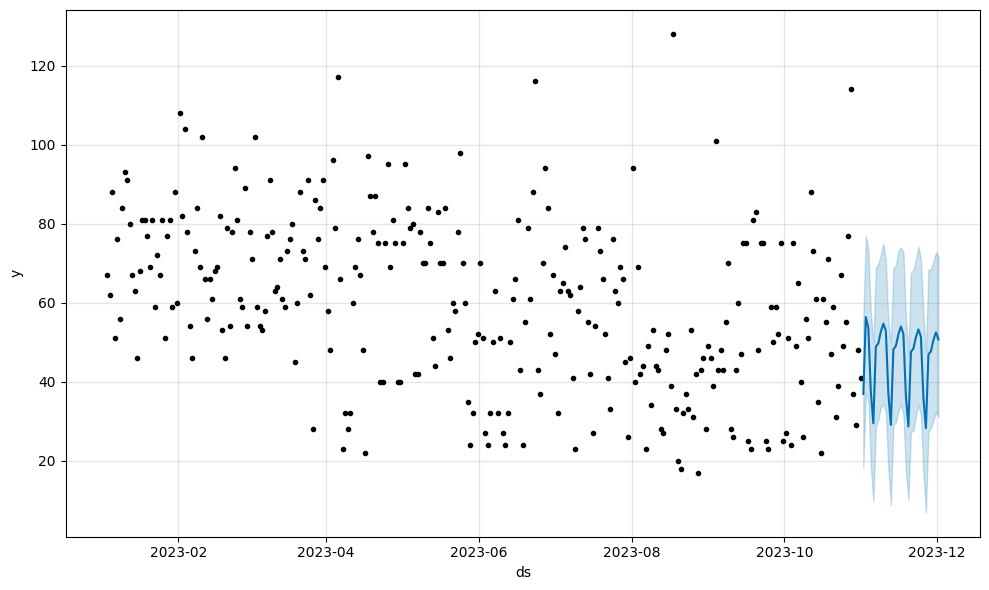

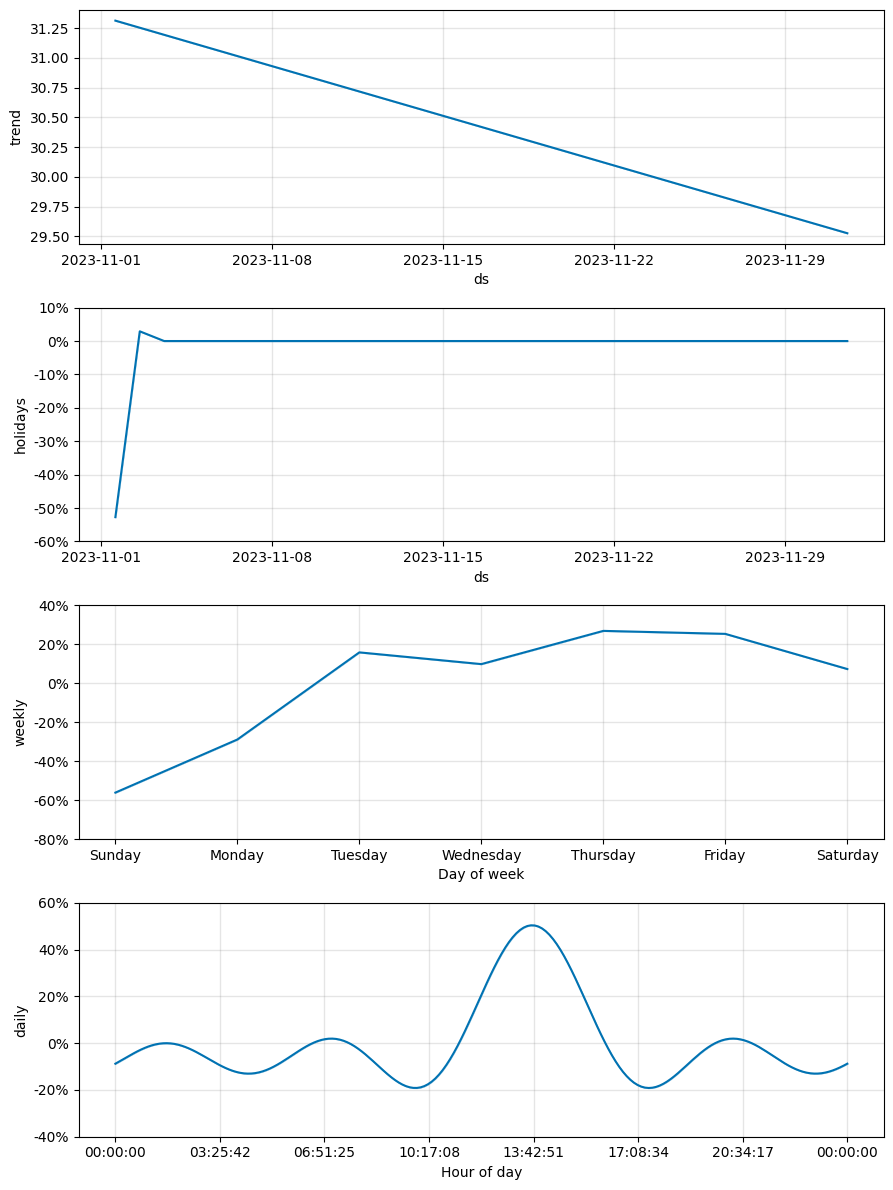

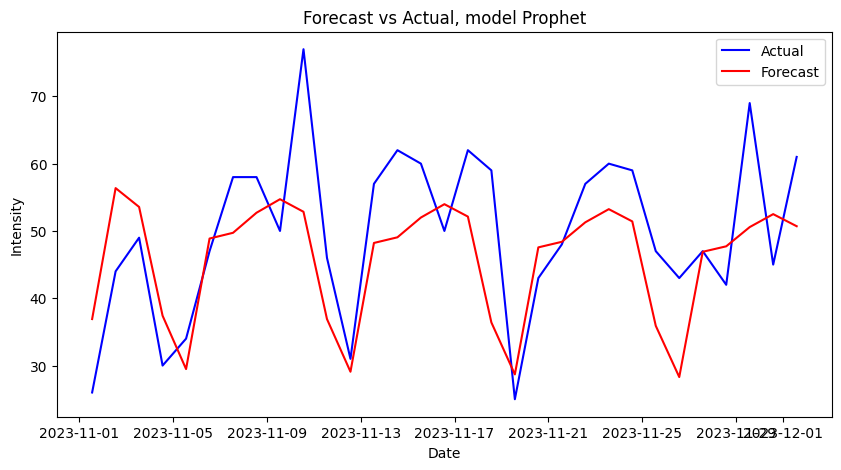

prophet    INFO  Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
cmdstanpy  DEBUG input tempfile: /var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/kr5orgso.json
cmdstanpy  DEBUG input tempfile: /var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/mhwpk2yr.json
cmdstanpy  DEBUG idx 0
cmdstanpy  DEBUG running CmdStan, num_threads: None
cmdstanpy  DEBUG CmdStan args: ['/Users/leilajavanmardi/Desktop/Leila/Coding_IronHack/Data_Analytics_Bootcamp/Finalproject/envfp/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57885', 'data', 'file=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/kr5orgso.json', 'init=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/mhwpk2yr.json', 'output', 'file=/var/folders/7n/f1mvr75d23s1g67jsx9pn8hr0000gn/T/tmpktfq7aez/prophet_modelq2jshek2/prophet_model-20240424225927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:27 - cmdstanpy - I

Mean Absolute Error (MAE): 8.32
Root Mean Squared Error (RMSE): 10.058
Mean Absolute Percentage Error (MAPE): 16.63%
Mean Absolute Scaled Error (MASE): 0.44%
Mean Absolute Error (MAE): 8.26
Root Mean Squared Error (RMSE): 9.927
Mean Absolute Percentage Error (MAPE): 16.62%
Mean Absolute Scaled Error (MASE): 0.44%


In [104]:
model = Prophet(
    changepoint_prior_scale=0.01905797698800418, 
    changepoint_range=0.7787414665722516, 
    daily_seasonality = True,
    #growth='linear',
    #interval_width=0.6134195282453077,
    n_changepoints=0,
    seasonality_mode= 'multiplicative', #'additive',
    seasonality_prior_scale=9.817619534889966,
    uncertainty_samples=1000, 
    #weekly_seasonality=False,
    yearly_seasonality= False, 
    #holidays= holidays
    holidays = holidayProphet
)

model.fit(data_trainp)

forecast = model.predict(forcast_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)



plt.figure(figsize=(10, 5))
plt.plot(data_testp['ds'], data_testp['y'], label='Actual', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], color='red', label='Forecast')
plt.title('Forecast vs Actual, model Prophet')
plt.xlabel('Date') 
plt.ylabel('Intensity') 
plt.legend()
plt.show()

# evaluation 
actual = data_testp['y'] 
predicted = forecast['yhat']
training = data_trainp['y']

mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")


# Model 2 
#========================================================

model = Prophet(
    changepoint_prior_scale=0.056412375199119064, 
    changepoint_range=0.6407631585364483, 
    #growth='linear',
    #daily_seasonality=True,
    #interval_width=0.18878144034686096,
    n_changepoints=5,
    seasonality_mode= 'multiplicative', #'additive',
    seasonality_prior_scale=1.883028744514034,
    uncertainty_samples=500, 
    #weekly_seasonality=True,
    yearly_seasonality= False, 
    #holidays= holidays
    holidays = holidayProphet
)

model.fit(data_trainp)

forecast = model.predict(forcast_df)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#fig1 = model.plot(forecast)
#fig2 = model.plot_components(forecast)

# evaluation 
actual = data_testp['y'] 
predicted = forecast['yhat']
training = data_trainp['y']

mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")

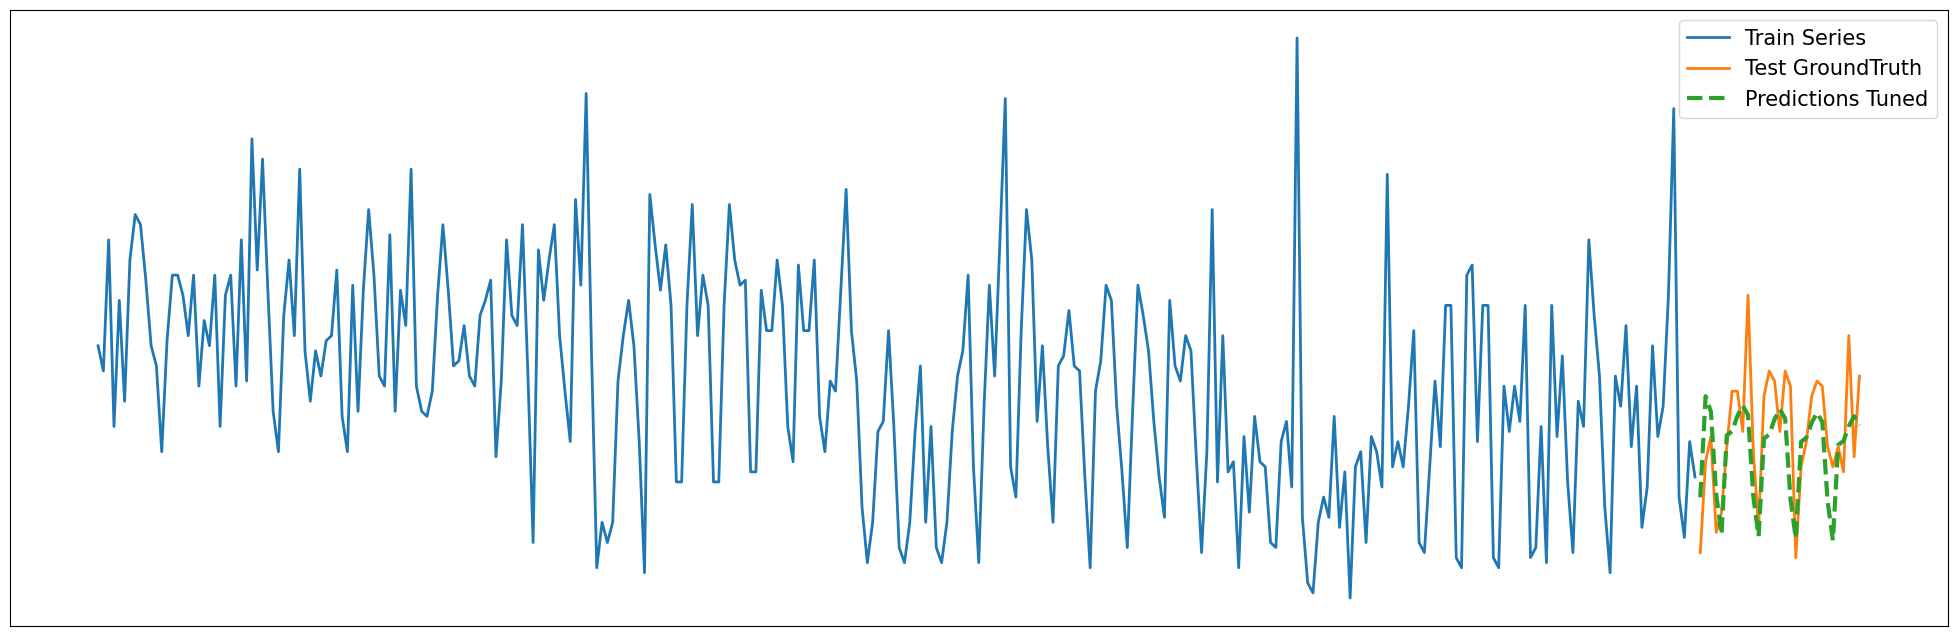

In [105]:
f = plt.figure()
f.set_figwidth(25)
f.set_figheight(8)

plt.plot(pd.to_datetime(data_trainp['ds']), data_trainp['y'], linewidth = 2, label = "Train Series")
plt.plot(pd.to_datetime(data_testp['ds']), data_testp['y'], linewidth = 2, label = "Test GroundTruth")
plt.plot(forecast['ds'], forecast['yhat'], linewidth = 3, label = "Predictions Tuned", linestyle='dashed')
#plt.plot(forecast2['ds'], forecast2['yhat'], linewidth = 3, label = "Predictions Default", linestyle='dashed')

plt.legend(fontsize=15)
#plt.ylabel('Intensity', fontsize = 15)
plt.xticks([])
plt.yticks([])
plt.show()

# Conclusion

In [106]:
print(f'The best model is the Prophet Model, which we optimized and fine-tuned. It has the following metrics:') 
mae = mean_absolute_error(actual, predicted)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

mape = np.mean(np.abs((actual - predicted) / actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

mase = calculate_mase(actual,predicted,training)
print(f"Mean Absolute Scaled Error (MASE): {mase:.2f}%")

The best model is the Prophet Model, which we optimized and fine-tuned. It has the following metrics:
Mean Absolute Error (MAE): 8.26
Root Mean Squared Error (RMSE): 9.927
Mean Absolute Percentage Error (MAPE): 16.62%
Mean Absolute Scaled Error (MASE): 0.44%


Future enhancements could involve including additional external factors such as weather conditions, and exploring hybrid models to further refine predictions, although suitable weather data was not available within the project timeframe.